### Problem List: 60, 61, 85

# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.22.4
tensorflow version = 2.6.0


In [40]:
import os
import cv2
import csv
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, concatenate, SimpleRNN, LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TerminateOnNaN, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt

In [41]:
seed_value = 10 #original

# seed_value = 20 #[RandomSeed]
# seed_value = 42 
# seed_value = 64
# seed_value = 100
# seed_value = 123
# seed_value = 200
# seed_value = 456
# seed_value = 1001
# seed_value = 12321

os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# GPU Setting

In [4]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Global Variables

In [6]:
KeypointsROOT = "../../2_EyeTrackingAnalysis/data/"
timeStamp_path = "_timeStamp_0916.csv" ### [update] 2023/09/16

n_FOLD = 5
n_FEATURE = 12
n_PERIOD = 300 
n_GAP = 150

isSeg = True  ### is Normalize by Segment or not

remove_dementia_pid_list = [22, 33, 57, 58, 64, 66, 67]
remove_dementia_pid_list_str = ['22', '33', '57', '58', '64', '66', '67']

# Load Timestamp

In [7]:
timeStamp_dict = {}
def load_timestamp():
    if not os.path.exists(timeStamp_path):
        print(f'[Timestamp] CSV does not exit.')
    else:
        df = pd.read_csv(timeStamp_path)
        df = df.fillna(0)
        n_row, n_col = df.shape[0], df.shape[1]
        
        data_dict = {}
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            start1 = int(float(df.iloc[idx, 1]))
            end1 = int(float(df.iloc[idx, 2]))
            data_dict[pid] = {}
            data_dict[pid]["1-start"] = start1
            data_dict[pid]["1-end"] = end1
    return data_dict

timeStamp_dict = load_timestamp()

print(f'=== number of pid in timeStamp CSV file: {len(timeStamp_dict)} ===\n')
print(timeStamp_dict)

=== number of pid in timeStamp CSV file: 100 ===

{1: {'1-start': 67, '1-end': 119}, 2: {'1-start': 111, '1-end': 149}, 3: {'1-start': 62, '1-end': 96}, 4: {'1-start': 111, '1-end': 150}, 5: {'1-start': 119, '1-end': 168}, 6: {'1-start': 57, '1-end': 79}, 7: {'1-start': 62, '1-end': 84}, 8: {'1-start': 93, '1-end': 110}, 9: {'1-start': 61, '1-end': 75}, 10: {'1-start': 106, '1-end': 128}, 11: {'1-start': 145, '1-end': 160}, 12: {'1-start': 73, '1-end': 109}, 13: {'1-start': 71, '1-end': 193}, 14: {'1-start': 59, '1-end': 79}, 15: {'1-start': 66, '1-end': 108}, 16: {'1-start': 91, '1-end': 139}, 17: {'1-start': 85, '1-end': 137}, 18: {'1-start': 90, '1-end': 118}, 19: {'1-start': 84, '1-end': 148}, 20: {'1-start': 71, '1-end': 101}, 21: {'1-start': 64, '1-end': 95}, 22: {'1-start': 87, '1-end': 118}, 23: {'1-start': 82, '1-end': 118}, 24: {'1-start': 80, '1-end': 231}, 25: {'1-start': 71, '1-end': 99}, 26: {'1-start': 72, '1-end': 115}, 27: {'1-start': 67, '1-end': 107}, 28: {'1-start':

# Load Label

In [8]:
Label_dict = {}
excel_path = "../Label_Data_Info.xlsx" 

df_label = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', '_Label']) # [update] 2023/06/17
df_label = df_label.fillna(0)
df_label = df_label.astype({"_Label": int})

Label_arr = np.array(df_label['_Label'])
Label_dict = dict(zip(df_label.編號, df_label._Label))

def checkDataDistribution(KeypointsROOT):
    labelList = []
    for folder in list(os.listdir(KeypointsROOT)):
        # if folder not in remove_dementia_pid_list_str:
        if int(folder) in timeStamp_dict and folder!="60" and folder!="61" and folder!="85": 
            label = Label_dict[int(folder)]
            labelList.append(label)
    lableArray = np.array(labelList)
    print(f'Data we have ...')
    print(f'# of AD pid: {np.count_nonzero(lableArray == 1)}')
    print(f'# of NC pid: {np.count_nonzero(lableArray == 0)}')
    print(f'total number of pid: {np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)}\n')
    print(f'Ratio (all guess Positive): {round(np.count_nonzero(lableArray == 1)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    print(f'Ratio (all guess Negative): {round(np.count_nonzero(lableArray == 0)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    
    
checkDataDistribution(KeypointsROOT)

print(Label_dict)

Data we have ...
# of AD pid: 29
# of NC pid: 67
total number of pid: 96

Ratio (all guess Positive): 0.3021
Ratio (all guess Negative): 0.6979
{1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}


# Load Video Type
* source file: **_videoType.csv**
* This file is produced from python file: **pre_cutVideo.ipynb**

In [9]:
videoType_dict = {}

def load_videoType_from_CSV_file(fileName):
    tmp_dict = {}
    if not os.path.exists(fileName):
        print(f'[VideoType] CSV does not exit.')
    else:
        df = pd.read_csv(fileName)
        n_row, n_col = df.shape[0], df.shape[1]
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            videotype = int(df.iloc[idx, 1])
            tmp_dict[pid] = videotype
    return tmp_dict
    
videoType_dict = load_videoType_from_CSV_file('_videoType.csv')
print(videoType_dict)

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 100: 2, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 83: 2, 84: 2, 85: 2, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2, 92: 2, 93: 2, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 99: 2}


# Load Subject ID

In [10]:
pid_dict = {}
allID_list = []

def load_id():
    data_dict = {}
    id_list = []
    
    for pid in list(os.listdir(KeypointsROOT)):
        # if pid not in remove_dementia_pid_list_str:
        if int(pid) in timeStamp_dict and pid!="60" and pid!="61" and pid!="85":
            data_dict[int(pid)] = pid
            id_list.append(pid)
    return data_dict, id_list

    
pid_dict, allID_list = load_id()

print(f'=== number of valid pid: {len(pid_dict)} ===')
print(pid_dict)

print(f'\n=== number of valid pid: {len(allID_list)} ===')
print(allID_list)

=== number of valid pid: 96 ===
{1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09', 10: '10', 100: '100', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80', 81: '81', 82: '82', 83: '83', 84: '84', 86: '86', 87: '87', 88: '88', 89: '89', 90: '90', 91: '91', 92: '92', 93: '93', 94: '94', 95: '95', 96: '96', 97: '97', 98: '98', 99: '99'}

=== number of

# Split Subject ID

In [11]:
trainID_5f, validateID_5f, testID_5f = [], [], []

def load_split_id_5fold_from_csv_file():
    train_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_train_5fold.csv'
    val_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_val_5fold.csv'
    test_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_test_5fold.csv'

    tmp_trainID_5f = []
    tmp_valID_5f = []
    tmp_testID_5f = []
    
    file_train = open(train_csv, "r")
    tmp_trainID_5f = list(csv.reader(file_train, delimiter=","))
    file_train.close()
    
    file_val = open(val_csv, "r")
    tmp_valID_5f = list(csv.reader(file_val, delimiter=","))
    file_val.close()
    
    file_test = open(test_csv, "r")
    tmp_testID_5f = list(csv.reader(file_test, delimiter=","))
    file_test.close()
    return tmp_trainID_5f, tmp_valID_5f, tmp_testID_5f


trainID_5f, validateID_5f, testID_5f = load_split_id_5fold_from_csv_file()

for i in range(n_FOLD):
    print(f'[Fold {i+1}] Total: {len(trainID_5f[i])+len(validateID_5f[i])+len(testID_5f[i])} subjects.')
    print(f'-Train: (num: {len(trainID_5f[i])})\n{trainID_5f[i]}')
    print(f'-Validate: (num: {len(validateID_5f[i])})\n{validateID_5f[i]}')
    print(f'-Test: (num: {len(testID_5f[i])})\n{testID_5f[i]}\n')    

[Fold 1] Total: 96 subjects.
-Train: (num: 62)
['15', '17', '18', '20', '23', '24', '25', '26', '27', '28', '31', '32', '33', '35', '38', '39', '40', '42', '43', '46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '57', '58', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '84', '86', '87', '88', '90', '91', '92', '93', '95', '96', '97', '98', '99']
-Validate: (num: 14)
['03', '05', '06', '07', '09', '10', '100', '12', '13', '16', '19', '21', '22', '30']
-Test: (num: 20)
['01', '02', '04', '08', '11', '14', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']

[Fold 2] Total: 96 subjects.
-Train: (num: 63)
['08', '14', '17', '18', '20', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '58', '59', '63', '64', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77'

In [12]:
# def remove_dementia_pid_from_data(train, val, test):
#     new_train_5f, new_val_5f, new_test_5f = [], [], []
#     for i in range(n_FOLD):
#         train_1f = train[i]
#         val_1f = val[i]
#         test_1f = test[i]

#         new_train, new_val, new_test = [], [], []

#         for idx, pid in enumerate(train_1f):
#             if pid not in remove_dementia_pid_list_str: new_train.append(pid)
#         for idx, pid in enumerate(val_1f):
#             if pid not in remove_dementia_pid_list_str: new_val.append(pid)
#         for idx, pid in enumerate(test_1f):
#             if pid not in remove_dementia_pid_list_str: new_test.append(pid)
#         new_train_5f.append(new_train)
#         new_val_5f.append(new_val)
#         new_test_5f.append(new_test)
#     return new_train_5f, new_val_5f, new_test_5f

# trainID_5f, validateID_5f, testID_5f = remove_dementia_pid_from_data(trainID_5f, validateID_5f, testID_5f)

In [13]:
def check_facial_subtask_pid(train_5f, val_5f, test_5f):
    ### check if all subjects are tested
    tmp_set = set()
    for i in range(n_FOLD):
        test_1f = test_5f[i]
        for j in range(len(test_1f)):
            pid = test_1f[j]
            tmp_set.add(pid)
    print(f'Number of pid in Test Set: {len(tmp_set)} subjects.\n')
    
    ### Check each fold (train + val + test)
    print(f'[Info] Check for each fold ...')
    for i in range(n_FOLD):
        tmp_set = set()
        for j in range(len(train_5f[i])):
            tmp_set.add(train_5f[i][j])
        for j in range(len(val_5f[i])):
            tmp_set.add(val_5f[i][j])
        for j in range(len(test_5f[i])):
            tmp_set.add(test_5f[i][j])
        print(f' -fold {i+1}: {len(tmp_set)} subjects.')
    
check_facial_subtask_pid(trainID_5f, validateID_5f, testID_5f)  

Number of pid in Test Set: 96 subjects.

[Info] Check for each fold ...
 -fold 1: 96 subjects.
 -fold 2: 96 subjects.
 -fold 3: 96 subjects.
 -fold 4: 96 subjects.
 -fold 5: 96 subjects.


# Load frame number

In [14]:
frameNum_dict = {}

def countFrames_part1(pidList):
    nSamples_dict = {}
    for pid in pidList:
        pid = int(pid)
        start = timeStamp_dict[pid]["1-start"]
        end = timeStamp_dict[pid]["1-end"]
        nSamples_dict[pid] = (end - start + 1) * 30
    return nSamples_dict

frameNum_dict = countFrames_part1(allID_list)

print(frameNum_dict)

{1: 1590, 2: 1170, 3: 1050, 4: 1200, 5: 1500, 6: 690, 7: 690, 8: 540, 9: 450, 10: 690, 100: 1530, 11: 480, 12: 1110, 13: 3690, 14: 630, 15: 1290, 16: 1470, 17: 1590, 18: 870, 19: 1950, 20: 930, 21: 960, 22: 960, 23: 1110, 24: 4560, 25: 870, 26: 1320, 27: 1230, 28: 780, 29: 810, 30: 1350, 31: 1890, 32: 1680, 33: 3240, 34: 780, 35: 1380, 36: 570, 37: 930, 38: 750, 39: 480, 40: 720, 42: 810, 43: 1110, 44: 1170, 45: 2310, 46: 930, 47: 390, 48: 1260, 49: 930, 50: 780, 51: 3030, 52: 750, 53: 900, 54: 1110, 55: 960, 56: 1020, 57: 840, 58: 2040, 59: 750, 62: 1950, 63: 3930, 64: 1560, 65: 1830, 66: 2550, 67: 1170, 68: 540, 69: 480, 70: 870, 71: 360, 72: 630, 73: 2280, 74: 750, 75: 960, 76: 870, 77: 960, 78: 1680, 79: 1290, 80: 750, 81: 1050, 82: 1050, 83: 1080, 84: 3420, 86: 1440, 87: 930, 88: 1980, 89: 1260, 90: 720, 91: 690, 92: 750, 93: 960, 94: 570, 95: 870, 96: 1020, 97: 1860, 98: 2370, 99: 2580}


# Load Coordinate data (5-Fold)

In [15]:
def normalize_segment(segment):
    n_row, n_col = segment.shape[0], segment.shape[1]

    for i in range(n_col):
        tmpList = [row[i] for row in segment]
        
        tmpArray = np.array(tmpList)
        tmpArray = tmpArray.reshape(len(tmpArray), 1)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaledArray = scaler.fit_transform(tmpArray)
        scaledArray = scaledArray.reshape(-1)
        if i==0:
            resultArray = scaledArray
        else:
            resultArray = np.vstack((resultArray, scaledArray))

    dataScaled = []
    nFrames = resultArray.shape[1]
    for i in range(nFrames):
        dataScaled.append([resultArray[0][i], resultArray[1][i],
                           resultArray[2][i], resultArray[3][i],
                           resultArray[4][i], resultArray[5][i],
                           resultArray[6][i], resultArray[7][i],
                           resultArray[8][i], resultArray[9][i],
                           resultArray[10][i], resultArray[11][i]])
    dataScaled = np.array(dataScaled)
    return dataScaled


def create_one_pid_all_segments_data(pid, pts):
    n_frame = len(pts)
    n_pair = int((n_frame - int(n_PERIOD)) / int(n_GAP)) + 1 

    start, end = 0, 0
    idxData, xData, yData = [], [], []
    segmentIdx = [] 
    for i in range(n_pair):
        end = start + int(n_PERIOD)
        
        x = pts[start:end, :]
        x = normalize_segment(x)
        x = np.transpose(x).astype(np.float32)
        # x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR) ### RGB image
        y = Label_dict[int(pid)]
        
        xData.append(x)
        yData.append(y)
        idxData.append(int(pid))
        segmentIdx.append(i)

        start += int(n_GAP)   
    return idxData, xData, yData, segmentIdx


def load_data_5fold_normalized_by_segment(KeypointsROOT, trainID, validateID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []
    segmentIdx_5f = [] 
    
    for i in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = [], [], []
        idxValidate_1f, xValidate_1f, yValidate_1f = [], [], []
        idxTest_1f, xTest_1f, yTest_1f = [], [], []
        segmentIdx_1f = []
        
        train_index = trainID[i]
        validate_index = validateID[i]
        test_index = testID[i]
        
        ### ============================================================= Train =============================================================
        for idx in train_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'{idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxTrain_1f.extend(idxData)
                xTrain_1f.extend(xData) 
                yTrain_1f.extend(yData)
        idxTrain_5f.append(idxTrain_1f)
        xTrain_5f.append(xTrain_1f)
        yTrain_5f.append(yTrain_1f)
        
        ### ============================================================= Validation =============================================================
        for idx in validate_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'{idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxValidate_1f.extend(idxData)
                xValidate_1f.extend(xData)
                yValidate_1f.extend(yData)
        idxValidate_5f.append(idxValidate_1f)
        xValidate_5f.append(xValidate_1f)
        yValidate_5f.append(yValidate_1f)
        
        ### ============================================================= Test =============================================================
        for idx in test_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'[Test] {idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                
                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxTest_1f.extend(idxData)
                xTest_1f.extend(xData)
                yTest_1f.extend(yData)
                segmentIdx_1f.extend(segmentIdx)
        idxTest_5f.append(idxTest_1f)
        xTest_5f.append(xTest_1f)
        yTest_5f.append(yTest_1f)
        segmentIdx_5f.append(segmentIdx_1f)
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f

In [16]:
idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
idxTest_5f, xTest_5f, yTest_5f = [], [], []
segmentIdx_5f = []


# if isSeg==False:
#     print(f'[INFO] Get data from [_normalized.csv] file directly.')
#     idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f \
#             = loadData_5fold(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)
# else:
print(f'[INFO] Normalize data by each segment.')
idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f\
        = load_data_5fold_normalized_by_segment(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)

[INFO] Normalize data by each segment.


In [17]:
for i in range(n_FOLD):
    ### ========================= Train =========================
    tmpIdx_train = np.array(idxTrain_5f[i])
    tmpX_train = np.array(xTrain_5f[i])
    tmpY_train = np.array(yTrain_5f[i])
    tmpIdx_train, tmpX_train, tmpY_train = shuffle(tmpIdx_train, tmpX_train, tmpY_train)
    idxTrain_5f[i] = tmpIdx_train
    xTrain_5f[i] = tmpX_train
    yTrain_5f[i] = tmpY_train
    
    ### ========================= Validation =========================
    tmpIdx_val = np.array(idxValidate_5f[i])
    tmpX_val = np.array(xValidate_5f[i])
    tmpY_val = np.array(yValidate_5f[i])
    tmpIdx_val, tmpX_val, tmpY_val = shuffle(tmpIdx_val, tmpX_val, tmpY_val)
    idxValidate_5f[i] = tmpIdx_val
    xValidate_5f[i] = tmpX_val
    yValidate_5f[i] = tmpY_val
    
    ### ========================= Test =========================
    tmpIdx_test = np.array(idxTest_5f[i])
    tmpX_test = np.array(xTest_5f[i])
    tmpY_test = np.array(yTest_5f[i])
    tmpSegIdx_test = np.array(segmentIdx_5f[i])
    ### UPDATE [2024/03/02] Do NOT shuffle the Testing data
    tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test = shuffle(tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test)
    idxTest_5f[i] = tmpIdx_test
    xTest_5f[i] = tmpX_test
    yTest_5f[i] = tmpY_test
    segmentIdx_5f[i] = tmpSegIdx_test


print(f'[Input Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {xTrain_5f[i].shape}, (Validate): {xValidate_5f[i].shape}, (Test): {xTest_5f[i].shape}')
print(f'\n[Target Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {yTrain_5f[i].shape}, (Validate): {yValidate_5f[i].shape}, (Test): {yTest_5f[i].shape}, (SegIdx): {segmentIdx_5f[i].shape}')

[Input Data]
- Fold 1 (Train): (472, 12, 300), (Validate): (100, 12, 300), (Test): (103, 12, 300)
- Fold 2 (Train): (457, 12, 300), (Validate): (96, 12, 300), (Test): (122, 12, 300)
- Fold 3 (Train): (478, 12, 300), (Validate): (78, 12, 300), (Test): (119, 12, 300)
- Fold 4 (Train): (408, 12, 300), (Validate): (108, 12, 300), (Test): (159, 12, 300)
- Fold 5 (Train): (394, 12, 300), (Validate): (109, 12, 300), (Test): (172, 12, 300)

[Target Data]
- Fold 1 (Train): (472,), (Validate): (100,), (Test): (103,), (SegIdx): (103,)
- Fold 2 (Train): (457,), (Validate): (96,), (Test): (122,), (SegIdx): (122,)
- Fold 3 (Train): (478,), (Validate): (78,), (Test): (119,), (SegIdx): (119,)
- Fold 4 (Train): (408,), (Validate): (108,), (Test): (159,), (SegIdx): (159,)
- Fold 5 (Train): (394,), (Validate): (109,), (Test): (172,), (SegIdx): (172,)


In [18]:
for i in range(n_FOLD):
    tmpY = np.array(yTrain_5f[i])
    print(f'- [Fold {i+1}] Train:    (AD): {np.count_nonzero(tmpY==1)}, (NC): {np.count_nonzero(tmpY==0)}')
    tmpY = np.array(yValidate_5f[i])
    print(f'  [Fold {i+1}] Validate: (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')
    tmpY = np.array(yTest_5f[i])
    print(f'  [Fold {i+1}] Test:     (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')

- [Fold 1] Train:    (AD): 148, (NC): 324
  [Fold 1] Validate: (AD): 18,  (NC): 82
  [Fold 1] Test:     (AD): 32,  (NC): 71
- [Fold 2] Train:    (AD): 135, (NC): 322
  [Fold 2] Validate: (AD): 17,  (NC): 79
  [Fold 2] Test:     (AD): 46,  (NC): 76
- [Fold 3] Train:    (AD): 161, (NC): 317
  [Fold 3] Validate: (AD): 13,  (NC): 65
  [Fold 3] Test:     (AD): 24,  (NC): 95
- [Fold 4] Train:    (AD): 133, (NC): 275
  [Fold 4] Validate: (AD): 19,  (NC): 89
  [Fold 4] Test:     (AD): 46,  (NC): 113
- [Fold 5] Train:    (AD): 124, (NC): 270
  [Fold 5] Validate: (AD): 24,  (NC): 85
  [Fold 5] Test:     (AD): 50,  (NC): 122


In [19]:
train_chekc_dict = {}
val_chekc_dict = {}
test_chekc_dict = {}

def get_fold_data_information(idxList, xList, yList, mode):
    print(f'========== {mode} ==========')
    tmp_dict = {}
    for i in range(n_FOLD):
        if i==0: f_name = "Fold1"
        elif i==1: f_name = "Fold2"
        elif i==2: f_name = "Fold3"
        elif i==3: f_name = "Fold4"
        elif i==4: f_name = "Fold5"
            
        tmp_dict[f_name] = {}

        tmp_pid = idxList[i]
        tmp_x = xList[i]
        tmp_y = yList[i]

        if len(tmp_pid)==len(tmp_x) and len(tmp_pid)==len(tmp_y):
            print(f'[Fold {i+1}] Same Number of Data: {len(tmp_pid)}')
        else:
            print(f'[Fold {i+1}] Wrong!!')

        unique_pid, countsPair = np.unique(tmp_pid, return_counts=True)

        for j in range(len(unique_pid)):
            pid = unique_pid[j]
            tmp_cnt = 0
            label = Label_dict[pid]
            for k in range(len(tmp_pid)):
                if tmp_pid[k]==pid:
                    tmp_cnt += 1
                    if tmp_y[k]!=label: print(f' - Label Wrong!!')
            if tmp_cnt!=countsPair[j]: print(f' - Num of Pairs Wrong!!')

            tmp_dict[f_name][pid] = {}
            tmp_dict[f_name][pid]["label"] = label
            tmp_dict[f_name][pid]["nPairs"] = countsPair[j]
    return tmp_dict
    
    
train_chekc_dict = get_fold_data_information(idxTrain_5f, xTrain_5f, yTrain_5f, "Train")
val_chekc_dict = get_fold_data_information(idxValidate_5f, xValidate_5f, yValidate_5f, "Validate")
test_chekc_dict = get_fold_data_information(idxTest_5f, xTest_5f, yTest_5f, "Test")

========== Train ==========
[Fold 1] Same Number of Data: 472
[Fold 2] Same Number of Data: 457
[Fold 3] Same Number of Data: 478
[Fold 4] Same Number of Data: 408
[Fold 5] Same Number of Data: 394
========== Validate ==========
[Fold 1] Same Number of Data: 100
[Fold 2] Same Number of Data: 96
[Fold 3] Same Number of Data: 78
[Fold 4] Same Number of Data: 108
[Fold 5] Same Number of Data: 109
========== Test ==========
[Fold 1] Same Number of Data: 103
[Fold 2] Same Number of Data: 122
[Fold 3] Same Number of Data: 119
[Fold 4] Same Number of Data: 159
[Fold 5] Same Number of Data: 172


In [20]:
def check_fold_split_correction(train_dict, val_dict, test_dict):
    for i in range(n_FOLD):
        if i==0: f_name = "Fold1"
        elif i==1: f_name = "Fold2"
        elif i==2: f_name = "Fold3"
        elif i==3: f_name = "Fold4"
        elif i==4: f_name = "Fold5"
        
        train_1f = train_dict[f_name]
        val_1f =  val_dict[f_name]
        test_1f =  test_dict[f_name]
        
        tmp_pid_list = []
        for key in train_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Train: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        for key in val_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Val: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        for key in test_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Test: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        print(f'[Fold {i+1}] Number of Subjects in this fold: {len(tmp_pid_list)}')
    
    
check_fold_split_correction(train_chekc_dict, val_chekc_dict, test_chekc_dict)

[Fold 1] Number of Subjects in this fold: 96
[Fold 2] Number of Subjects in this fold: 96
[Fold 3] Number of Subjects in this fold: 96
[Fold 4] Number of Subjects in this fold: 96
[Fold 5] Number of Subjects in this fold: 96


# Feature Selection (Dynamic)

## Select Features

In [21]:
best_threshold_5f_List = []
best_f1score_5f_List = []


LOAD_MODEL_FOLDER = "LOG/Facial_RandomSeed/" + str(10) + "/Model_Weights/" # [RandomSeed]
LOAD_PARAMETER_FOLDER = "LOG/Facial_RandomSeed/" + str(10) + "/Parameters/"
print(f'[Loading...] Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')
print(f'[Loading...] Load thresholds from FOLDER:    {LOAD_PARAMETER_FOLDER}')


SAVE_PARAMETER_FOLDER = "LOG_FS/Facial_RandomSeed/" + str(seed_value) + "/Parameters/"  # [RandomSeed]
print(f'[Saving....] Save thresholds to FOLDER:    {SAVE_PARAMETER_FOLDER}\n')


def read_parameters_from_csv(threshold_file_name, f1score_file_name):
    threshold_list, f1score_list = [], []
    with open(threshold_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        threshold_list_string = next(rows)
    for num in threshold_list_string:
        threshold_list.append(float(num))
    with open(f1score_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        f1score_list_string = next(rows)
    for num in f1score_list_string:
        f1score_list.append(float(num))
        
    return threshold_list, f1score_list

best_threshold_5f_List, best_f1score_5f_List = read_parameters_from_csv(LOAD_PARAMETER_FOLDER+'threshold_5fold.csv', LOAD_PARAMETER_FOLDER+'f1Score_5fold.csv')
print(f'best_threshold_5f_List:\n{best_threshold_5f_List}\n')
print(f'best_f1score_5f_List:\n{best_f1score_5f_List}')

[Loading...] Load model weights from FOLDER: LOG/Facial_RandomSeed/10/Model_Weights/
[Loading...] Load thresholds from FOLDER:    LOG/Facial_RandomSeed/10/Parameters/
[Saving....] Save thresholds to FOLDER:    LOG_FS/Facial_RandomSeed/10/Parameters/

best_threshold_5f_List:
[0.41000000000000003, 0.4, 0.5100000000000001, 0.45000000000000007, 0.41000000000000003]

best_f1score_5f_List:
[0.2564102564102564, 0.16326530612244897, 0.2222222222222222, 0.2, 0.22950819672131148]


In [22]:
def fs_make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def feature_selection_with_GradCAM_dynamic():
    selected_feature_idx = []
    sum_of_each_feature = [0] * n_FEATURE
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ----------------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Load data -------------------------------------------------------------------
        valID_1f = validateID_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]
        threshold = best_threshold_5f_List[fold_idx]

        ### Feature Selection with Validation Data ---------------------------------------
        for pid in valID_1f:
            pid = int(pid)
            label = Label_dict[pid]

            selected_data_idx = []
            prob_list = []
            for idx in range(len(idxVal_1f)):
                tmp_pid = idxVal_1f[idx]
                if tmp_pid == pid:
                    data = xVal_1f[idx]
                    n_feature, n_timestamp = data.shape[0], data.shape[1]
                    data = np.expand_dims(data, axis=0)
                    data = data.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)
                    tmp_prob = model.predict(data)
                    prob_list.append(tmp_prob)

            target_prob, target_index = 0, 0
            if label==0:
                target_prob, target_index = np.min(prob_list), np.argmin(prob_list)
            if label==1:
                target_prob, target_index = np.max(prob_list), np.argmax(prob_list)

            ### Run on target most important data ------------------------------------------------
            target_data = xVal_1f[target_index]
            n_feature, n_timestamp = target_data.shape[0], target_data.shape[1]
            target_data = np.expand_dims(target_data, axis=0)
            target_data = target_data.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)
            
            heatmap = fs_make_gradcam_heatmap(target_data, model, 'last_conv') 
            heatmap = np.uint8(255*heatmap)
            heatmap = cv2.resize(heatmap, (n_timestamp, n_feature))
            for feature_idx, value in enumerate(heatmap):
                sum_of_each_feature[feature_idx] += np.average(value)
                
    sum_of_each_feature_scaled = sum_of_each_feature.copy()
    tmp_sum = np.sum(sum_of_each_feature_scaled)
    for fidx, feat in enumerate(sum_of_each_feature_scaled):
        sum_of_each_feature_scaled[fidx] = 1/tmp_sum * sum_of_each_feature_scaled[fidx]
    
    sum_of_each_feature_scaled_sort = sum_of_each_feature_scaled.copy()
    sum_of_each_feature_scaled_sort.sort()

    imp_sumup = 0
    selected_feature_idx = []
    for impIdx, imp in reversed(list(enumerate(sum_of_each_feature_scaled_sort))):
        imp_sumup += imp
        selected_feature_idx.append(impIdx)
        print(f'[impIdx, imp, sum] = [{impIdx}, {imp}, {imp_sumup}]')
        if imp_sumup > 0.8:
            break
    selected_feature_idx.sort()
    return selected_feature_idx


selected_features = []
selected_features = feature_selection_with_GradCAM_dynamic()

n_SELECTED_FEATURE = len(selected_features)

print(f'\nn_SELECTED_FEATURE = {n_SELECTED_FEATURE}')
print(f'\nFeature selected with validation data:\n{len(selected_features)} features: {selected_features}')

[impIdx, imp, sum] = [11, 0.08793837043757559, 0.08793837043757559]
[impIdx, imp, sum] = [10, 0.08775003088363652, 0.1756884013212121]
[impIdx, imp, sum] = [9, 0.08635955843487808, 0.2620479597560902]
[impIdx, imp, sum] = [8, 0.08535629590776626, 0.34740425566385646]
[impIdx, imp, sum] = [7, 0.08524450726929923, 0.4326487629331557]
[impIdx, imp, sum] = [6, 0.0832481079975455, 0.5158968709307012]
[impIdx, imp, sum] = [5, 0.08201559775531655, 0.5979124686860178]
[impIdx, imp, sum] = [4, 0.08127722569761578, 0.6791896943836335]
[impIdx, imp, sum] = [3, 0.0812427980372183, 0.7604324924208519]
[impIdx, imp, sum] = [2, 0.08104838301379737, 0.8414808754346492]

n_SELECTED_FEATURE = 10

Feature selected with validation data:
10 features: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [23]:
def save_feature_index_to_CSV():
    if not os.path.exists(SAVE_PARAMETER_FOLDER):
        os.makedirs(SAVE_PARAMETER_FOLDER)
    feature_file_name = SAVE_PARAMETER_FOLDER + 'featureIdx_5fold.csv'
    df_selected_feature_idx = pd.DataFrame(selected_features)
    df_selected_feature_idx.to_csv(feature_file_name, index=False, header=False)
        
save_feature_index_to_CSV()

## Reload data

In [21]:
n_MODEL = 3

# MAX_EPOCHS = 75
# MAX_EPOCHS = 30
MAX_EPOCHS = 50
# MAX_EPOCHS = 20
BATCH_SIZE = 32
# BATCH_SIZE = 16
Threshold = 0.5

best_threshold_5f_List = []
best_f1score_5f_List = []


SAVE_MODEL_FOLDER = "LOG_FS/Facial_RandomSeed/" + str(seed_value) + "/Model_Weights/" # [RandomSeed]
SAVE_PARAMETER_FOLDER = "LOG_FS/Facial_RandomSeed/" + str(seed_value) + "/Parameters/"

print(f'Save model weights to FOLDER: {SAVE_MODEL_FOLDER}')
print(f'Save thresholds to FOLDER:    {SAVE_PARAMETER_FOLDER}')

Save model weights to FOLDER: LOG_FS/Facial_RandomSeed/10/Model_Weights/
Save thresholds to FOLDER:    LOG_FS/Facial_RandomSeed/10/Parameters/


In [22]:
selected_features = []
n_SELECTED_FEATURE = 0

def read_featureIdx_from_csv(featureIdx_file_name):
    featureIdx_list = []
    df = pd.read_csv(featureIdx_file_name, header=None)
    n_row, n_col = df.shape[0], df.shape[1]
    for i in range(n_row):
        featureIdx_list.append(df.iloc[i, :].values[0])
    return featureIdx_list

# selected_features= read_featureIdx_from_csv(SAVE_PARAMETER_FOLDER + 'featureIdx_5fold.csv')
selected_features= read_featureIdx_from_csv("LOG_FS/Facial_RandomSeed/10/Parameters/featureIdx_5fold.csv")
n_SELECTED_FEATURE = len(selected_features)

print(f'n_SELECTED_FEATURE = {n_SELECTED_FEATURE}')
print(f'\nselected_features: {selected_features}')

n_SELECTED_FEATURE = 10

selected_features: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [23]:
new_xTrain_5f, new_xVal_5f, new_xTest_5f = [], [], []

def feature_selection_reconstruct_data():
    tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f = [], [], []
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]

        tmp_xTrain_1f, tmp_xVal_1f, tmp_xTest_1f = [], [], []

        top_feature_idx = selected_features

        for data in xTrain_1f:
            data = data[top_feature_idx]
            tmp_xTrain_1f.append(data)
        tmp_xTrain_1f = np.array(tmp_xTrain_1f)
        tmp_xTrain_5f.append(tmp_xTrain_1f)
        
        for data in xVal_1f:
            data = data[top_feature_idx]
            tmp_xVal_1f.append(data)
        tmp_xVal_1f = np.array(tmp_xVal_1f)
        tmp_xVal_5f.append(tmp_xVal_1f)

        for data in xTest_1f:
            data = data[top_feature_idx]
            tmp_xTest_1f.append(data)
        tmp_xTest_1f = np.array(tmp_xTest_1f)
        tmp_xTest_5f.append(tmp_xTest_1f)
    return tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f


new_xTrain_5f, new_xVal_5f, new_xTest_5f = feature_selection_reconstruct_data()


print(f'[Feature Selection]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {new_xTrain_5f[i].shape}, (Validate): {new_xVal_5f[i].shape}, (Test): {new_xTest_5f[i].shape}')

[Feature Selection]
- Fold 1 (Train): (472, 10, 300), (Validate): (100, 10, 300), (Test): (103, 10, 300)
- Fold 2 (Train): (457, 10, 300), (Validate): (96, 10, 300), (Test): (122, 10, 300)
- Fold 3 (Train): (478, 10, 300), (Validate): (78, 10, 300), (Test): (119, 10, 300)
- Fold 4 (Train): (408, 10, 300), (Validate): (108, 10, 300), (Test): (159, 10, 300)
- Fold 5 (Train): (394, 10, 300), (Validate): (109, 10, 300), (Test): (172, 10, 300)


## Training

### Train & Save models

In [24]:
def build_model_structure():
    ### ---------------------------- Model 3 ----------------------------
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(1, 30), activation='relu', strides=1, padding='SAME', input_shape=(n_SELECTED_FEATURE, int(n_PERIOD), 1), name='first_conv')) ### grayscale image
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.25))
    model.add(Conv2D(8, kernel_size=(1, 30), activation='relu', strides=1, name='last_conv'))
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [25]:
best_threshold_5f_List = []
best_f1score_5f_List = []

def find_best_threshold_tuning(yTrue, yPred_prob):
    scores = []
    thresholds = np.arange(0.40, 0.60, 0.01)
    # thresholds = np.arange(0.30, 0.70, 0.01)
    for t in thresholds:
        yPred = (yPred_prob >= t).astype('int')
        score = f1_score(yTrue, yPred)
        scores.append(score)
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    best_f1score = scores[ix]
    return best_threshold, best_f1score


def feature_selection_train_and_save_model():
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], new_xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], new_xVal_5f[fold_idx], yValidate_5f[fold_idx]
        
        xTrain_1f = xTrain_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1) ### shape = (n_samples, 10, 300, 1)
        xVal_1f = xVal_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1)

        best_auc = 0
        best_model_idx = 0
        best_threshold = 0

        for model_idx in range(n_MODEL):
            print(f'[Feature Selection] Training for [Fold {fold_idx+1}] model {model_idx+1} ...')
            model = build_model_structure()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = model.fit(xTrain_1f, yTrain_1f, 
                                epochs=MAX_EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                validation_data=(xVal_1f, yVal_1f), 
                                shuffle=True, 
                                verbose=0)
            
            yPred_val = model.predict(xVal_1f)
            aucScore_val = roc_auc_score(yVal_1f, yPred_val)
            if aucScore_val > best_auc:
                best_auc = aucScore_val
                best_model = model

        ### Use F1-Score & Validation Data to Find threshold which will be used with Test Data ----------
        yPred_val = best_model.predict(xVal_1f)
        best_threshold, best_f1score = find_best_threshold_tuning(yVal_1f, yPred_val)
        best_threshold_5f_List.append(best_threshold)
        best_f1score_5f_List.append(best_f1score)

        ### Save best model -----------------------------------------------------------------------------
        if not os.path.exists(SAVE_MODEL_FOLDER):
            os.makedirs(SAVE_MODEL_FOLDER)
        best_model.save(f'{SAVE_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(best_model.summary())

    if not os.path.exists(SAVE_PARAMETER_FOLDER):
        os.makedirs(SAVE_PARAMETER_FOLDER)
    threshold_file_name = SAVE_PARAMETER_FOLDER + 'threshold_5fold.csv'
    f1score_file_name = SAVE_PARAMETER_FOLDER + 'f1Score_5fold.csv'
    with open(threshold_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(best_threshold_5f_List)
    with open(f1score_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(best_f1score_5f_List)


feature_selection_train_and_save_model()

[Feature Selection] Training for [Fold 1] model 1 ...
[Feature Selection] Training for [Fold 1] model 2 ...
[Feature Selection] Training for [Fold 1] model 3 ...
[Feature Selection] Training for [Fold 2] model 1 ...
[Feature Selection] Training for [Fold 2] model 2 ...
[Feature Selection] Training for [Fold 2] model 3 ...
[Feature Selection] Training for [Fold 3] model 1 ...
[Feature Selection] Training for [Fold 3] model 2 ...
[Feature Selection] Training for [Fold 3] model 3 ...
[Feature Selection] Training for [Fold 4] model 1 ...
[Feature Selection] Training for [Fold 4] model 2 ...
[Feature Selection] Training for [Fold 4] model 3 ...
[Feature Selection] Training for [Fold 5] model 1 ...
[Feature Selection] Training for [Fold 5] model 2 ...
[Feature Selection] Training for [Fold 5] model 3 ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv (Conv2D)          (None,

## Evaluate & Results

### Average

In [26]:
best_threshold_5f_List = []
best_f1score_5f_List = []

LOAD_MODEL_FOLDER = "LOG_FS/Facial_RandomSeed/" + str(seed_value) + "/Model_Weights/" #[RandomSeed]
LOAD_PARAMETER_FOLDER = "LOG_FS/Facial_RandomSeed/" + str(seed_value) + "/Parameters/"

def read_parameters_from_csv(threshold_file_name, f1score_file_name):
    threshold_list, f1score_list = [], []
    with open(threshold_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        threshold_list_string = next(rows)
    for num in threshold_list_string:
        threshold_list.append(float(num))
    with open(f1score_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        f1score_list_string = next(rows)
    for num in f1score_list_string:
        f1score_list.append(float(num))
    return threshold_list, f1score_list

best_threshold_5f_List, best_f1score_5f_List = read_parameters_from_csv(LOAD_PARAMETER_FOLDER+'threshold_5fold.csv', LOAD_PARAMETER_FOLDER+'f1Score_5fold.csv')
print(f'best_threshold_5f_List:\n{best_threshold_5f_List}\n')
print(f'best_f1score_5f_List:\n{best_f1score_5f_List}')

best_threshold_5f_List:
[0.43000000000000005, 0.4, 0.43000000000000005, 0.4600000000000001, 0.43000000000000005]

best_f1score_5f_List:
[0.18604651162790697, 0.36363636363636365, 0.17777777777777778, 0.23529411764705882, 0.24489795918367346]


In [27]:
def check_performance_with_best_threshold(idxList, answerList, predictionList, best_threshold):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)
    n_Correct = 0

    ### Loop through each pid in test list
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        prob = 0
        
        ### get the actual label (target) of this pid
        actual_label = Label_dict[pid]

        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                prob += round(predictionList[j][0], 4)
                
        ### calculate the average prediction prob of this pid
        avegProb = prob / nPairs
        
        if avegProb >= best_threshold:
            predict_label = 1
            actual_label_List.append(actual_label)
            predict_label_List.append(predict_label)    
        else:
            predict_label = 0
            actual_label_List.append(actual_label)
            predict_label_List.append(predict_label)
            
        if predict_label==actual_label:
            n_Correct += 1
        
        result_dict[pid] = {}
        result_dict[pid]["avegProb"] = round(avegProb, 4)
        result_dict[pid]["n_pairs"] = nPairs
        result_dict[pid]["prediction"] = predict_label
        result_dict[pid]["actual"] = actual_label
    return n_Correct, len(uniqueID_test)

def get_prob_of_each_segment(pidList, segmentList, prediction):
    for i in range(len(pidList)):
        pid = pidList[i]
        seg = segmentList[i]
        pred = prediction[i]
        if pid not in result_segment_dict:
            result_segment_dict[pid] = {}
        segName = "segment_" + str(seg)
        result_segment_dict[pid][segName] = round(pred[0], 4)

In [28]:
actual_label_List= []
predict_label_List = []

result_dict = {}
result_dict_sorted = {}

result_segment_dict = {}
result_segment_dict_sorted = {}


def load_model_and_evaluate_model():
    metrics_auc_5f = []
    metrics_acc_5f = []
    metrics_loss_5f = []
    nb_correction_5f = []
    nb_testing_5f = []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1) ### grayscale image
        # xTest_1f = xTest_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 3) ### RGB image

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        auc = roc_auc_score(yTest_1f, yPred)
        metrics_auc_5f.append(round(auc, 2))
        scores = model.evaluate(xTest_1f, yTest_1f, verbose=0)
        metrics_acc_5f.append(round(scores[1], 2))
        metrics_loss_5f.append(round(scores[0], 2))

        # ### Check model performance with Threshold(=0.5) or best_threshold
        threshold = best_threshold_5f_List[fold_idx]
        nb_correction, nb_testing = check_performance_with_best_threshold(idxTest_1f, yTest_1f, yPred, threshold)
        get_prob_of_each_segment(idxTest_1f, segmentIdx_1f, yPred)
        nb_correction_5f.append(nb_correction)
        nb_testing_5f.append(nb_testing)
    return nb_correction_5f, nb_testing_5f, metrics_auc_5f, metrics_acc_5f, metrics_loss_5f


correctionList, testNumList, aucList, accList, lossList = load_model_and_evaluate_model()

In [29]:
total_Correction, total_Pid = 0, 0
for i in range(n_FOLD):
    print(f'- Fold {i+1}: {correctionList[i]}/{testNumList[i]}, AUC: {aucList[i]}, accuracy: {accList[i]}, loss: {lossList[i]}')
    total_Correction += correctionList[i]
    total_Pid += testNumList[i]
    
print(f'Performance: {total_Correction}/{total_Pid}, Ratio: {round(total_Correction/total_Pid*100, 2)}%')

- Fold 1: 14/20, AUC: 0.49, accuracy: 0.59, loss: 0.8
- Fold 2: 12/19, AUC: 0.53, accuracy: 0.63, loss: 0.74
- Fold 3: 10/19, AUC: 0.52, accuracy: 0.62, loss: 0.68
- Fold 4: 10/18, AUC: 0.41, accuracy: 0.56, loss: 0.81
- Fold 5: 12/20, AUC: 0.42, accuracy: 0.57, loss: 0.89
Performance: 58/96, Ratio: 60.42%


==============  Classification Report  ==============
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        67
           1       0.29      0.21      0.24        29

    accuracy                           0.60        96
   macro avg       0.49      0.49      0.49        96
weighted avg       0.57      0.60      0.58        96

==================  Performance  ====================
0) TN: 52, FP: 15, FN: 23, TP: 6
1) Accuracy: 60.42%
2) Sensitivity (Recall): 20.69%
3) Specificity: 77.61%
4) G-Mean: 40.07%
5) Precision: 28.57%
6) F1-Score: 0.24
7) F2-Measure: 0.22



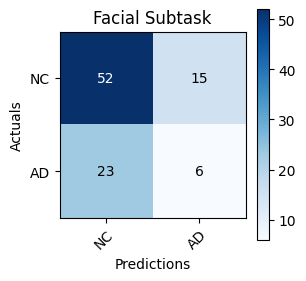

In [30]:
from mlxtend.plotting import plot_confusion_matrix

def show_confusion_matrix():
    actual_label_array = np.array(actual_label_List)
    predict_label_array = np.array(predict_label_List)

    ### F1-Score
    print(f'==============  Classification Report  ==============')
    print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Facial Subtask', fontsize=12)
    plt.show()


    
show_confusion_matrix()

### Weighted

In [31]:
import sys

==================  Performance  ====================
0) TN: 62, FP: 5, FN: 13, TP: 16
1) Accuracy: 81.25%
2) Sensitivity (Recall): 55.17%
3) Specificity: 92.54%
4) G-Mean: 71.45%
5) Precision: 76.19%
6) F1-Score: 0.64
7) F2-Measure: 0.58



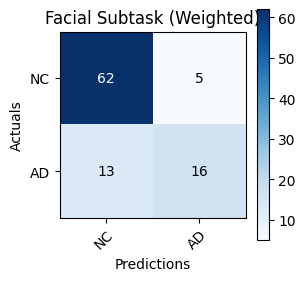

In [32]:
result_weighted_dict = {}
result_weighted_dict_sorted = {}

def evaluate_model_with_confidence():
    actual_label_weighted_List= []
    predict_label_weighted_List = []
    for fold_idx in range(n_FOLD):
        testID = testID_5f[fold_idx]
        for pid in testID:
            result = result_segment_dict[int(pid)]
            predict_label = 0
            label = Label_dict[int(pid)]
            threshold = best_threshold_5f_List[fold_idx]

            segmentName, prediction = [], []
            for key in result:
                prediction.append(result_segment_dict[int(pid)][key])
                segmentName.append(key)
            prediction = np.array(prediction)
            minPred, minIdx = np.min(prediction), np.argmin(prediction)
            maxPred, maxIdx = np.max(prediction), np.argmax(prediction)
            # print(f'[Pid {pid}] Label={label} {prediction}\nmin: {minPred}, {minIdx}\nmax: {maxPred}, {maxIdx}')

            ### Run Grad-CAM ------------------------------------------------------------------------------------
            mean_weighted = 0
            if label==0: ### NC
                eps = sys.float_info.epsilon
                prediction = [w if w != 0 else eps for w in prediction]
                prediction = np.array(prediction)
                mean_weighted = np.average(prediction, weights=1/prediction)
                # print(f'mean: {np.average(prediction)}, mean_weighted: {np.average(prediction, weights=1/prediction)}\n')
            if label==1: ### AD
                mean_weighted = np.average(prediction, weights=prediction)
                # print(f'mean: {np.average(prediction)}, mean_weighted: {np.average(prediction, weights=prediction)}\n')

            if mean_weighted >= threshold: predict_label = 1
            else: predict_label = 0
                
            actual_label_weighted_List.append(label)
            if mean_weighted >= threshold: predict_label_weighted_List.append(predict_label)
            else: predict_label_weighted_List.append(predict_label)

            result_weighted_dict[int(pid)] = {}
            result_weighted_dict[int(pid)]["avegProb_weighted"] = round(mean_weighted, 4)
            result_weighted_dict[int(pid)]["prediction"] = predict_label
            result_weighted_dict[int(pid)]["actual"] = label
    

    ### Confusion Matrix ----------------------------------------------------------------------------------------
    actual_label_weighted_array, predict_label_weighted_array = np.array(actual_label_weighted_List), np.array(predict_label_weighted_List)
    matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Facial Subtask (Weighted)', fontsize=12)
    plt.show()


evaluate_model_with_confidence() 

In [33]:
def check_the_difference_between_two_results(): ### result_dict, result_weighted_dict
    if len(result_dict) != len(result_weighted_dict):
        print(f'!!! NOTICE !!! Elements in two result_dict & result_weighted_dict are not the same!')
    for key in result_dict:
        pred1 = result_dict[key]["prediction"]
        prob1 = result_dict[key]["avegProb"]
        pred2 = result_weighted_dict[key]["prediction"]
        prob2 = result_weighted_dict[key]["avegProb_weighted"]
        truth = result_dict[key]["actual"]
        if pred1 != pred2:
            print(f'[Pid {key}] Label: {truth}, Pred: {pred1}({prob1}) -> {pred2}({prob2})')


check_the_difference_between_two_results()

[Pid 45] Label: 1, Pred: 0(0.3455) -> 1(0.5507000088691711)
[Pid 23] Label: 1, Pred: 0(0.3835) -> 1(0.42820000648498535)
[Pid 62] Label: 1, Pred: 0(0.2807) -> 1(0.42579999566078186)
[Pid 65] Label: 1, Pred: 0(0.3652) -> 1(0.43479999899864197)
[Pid 66] Label: 0, Pred: 1(0.4231) -> 0(0.39149999618530273)
[Pid 96] Label: 0, Pred: 1(0.4275) -> 0(0.3659000098705292)
[Pid 3] Label: 0, Pred: 1(0.4588) -> 0(0.32739999890327454)
[Pid 33] Label: 0, Pred: 1(0.5053) -> 0(0.16300000250339508)
[Pid 46] Label: 1, Pred: 0(0.3216) -> 1(0.4611000120639801)
[Pid 72] Label: 0, Pred: 1(0.4719) -> 0(0.2529999911785126)
[Pid 86] Label: 0, Pred: 1(0.4642) -> 0(0.41440001130104065)
[Pid 16] Label: 1, Pred: 0(0.4251) -> 1(0.5394999980926514)
[Pid 27] Label: 1, Pred: 0(0.357) -> 1(0.4661000072956085)
[Pid 38] Label: 1, Pred: 0(0.2479) -> 1(0.4629000127315521)
[Pid 50] Label: 0, Pred: 1(0.4644) -> 0(0.4438000023365021)
[Pid 78] Label: 0, Pred: 1(0.4602) -> 0(0.3456000089645386)
[Pid 17] Label: 1, Pred: 0(0.3031) 

### Grad-CAM

In [33]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



def show_GradCAM_result():
    for fold_idx in range(n_FOLD):
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]

        selected_feature = selected_features

        feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                             'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
        new_feature_name_list = []
        for feat_idx in selected_feature:
            new_feature_name_list.append(feature_name_list[feat_idx])
        print(f'selected_feature: {selected_feature}')
        print(f'new_feature_name_list: {new_feature_name_list}')
        

        for test_idx in range(len(idxTest_1f)):
            pid = idxTest_1f[test_idx]
            segmentIdx = segmentIdx_1f[test_idx]

            # if pid==60 or pid==36:
            # if pid==16:
            if pid == 65:
                test_data = xTest_1f[test_idx]
                width, height = test_data.shape[1], test_data.shape[0]
                test_data = np.expand_dims(test_data, axis=0) 
                
                label = Label_dict[pid]
                pred_average = result_dict[pid]["prediction"]
                pred_weighted = result_weighted_dict[pid]["prediction"]

                segName = "segment_" + str(segmentIdx)
                prob = result_segment_dict[pid][segName]
                
                heatmap = make_gradcam_heatmap(test_data, model, 'last_conv') 
                heatmap = np.uint8(255*heatmap)
                heatmap = cv2.resize(heatmap, (width, height))
                
                plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)                
                print(f'------------------------------- [Pid {pid}] [Fold {fold_idx}] Prob: {prob}, Segment: {segmentIdx} -------------------------------')
                print(f'--------------------------------- Label: {label}, Pred_average: {pred_average}, Pred_weighted: {pred_weighted}  ------------------------------')
                plt.figure(figsize=(20, 12))
                for featureIdx in range(n_SELECTED_FEATURE):
                    plt.subplot(4, 3, featureIdx+1)
                    plt.title(f'Feature: {new_feature_name_list[featureIdx]}', fontsize=10)
                    plt.imshow(np.expand_dims(heatmap[featureIdx], axis=0), cmap='viridis', aspect='auto', interpolation='nearest', 
                               vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0, 
                               extent=[0, n_PERIOD, round(test_data[0][featureIdx,:].min()*1.05), round(test_data[0][featureIdx,:].max()*1.05)])
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show()   




def show_GradCAM_with_higher_confidence():
    for fold_idx in range(n_FOLD):
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        testID = testID_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]

        selected_feature = selected_features

        feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                             'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
        new_feature_name_list = []
        for feat_idx in selected_feature:
            new_feature_name_list.append(feature_name_list[feat_idx])
        print(f'selected_feature: {selected_feature}')
        print(f'new_feature_name_list: {new_feature_name_list}')

        for pid in testID:
            pid = int(pid)
            label = Label_dict[pid]
            pred_average = result_dict[pid]["prediction"]
            pred_weighted = result_weighted_dict[pid]["prediction"]
            confidence_idx = 0
            confidence_value = 0
            if label==0: ### -------------------------------------- [Noted] ------------------------------------------- ### 
                confidence_value = 100
            confidence_segment = 0
            # if pid == 59:
            if pid == 65:
                if label==1:
                    for testIdx, testPid in enumerate(idxTest_1f):
                        if testPid == pid:
                            seg = segmentIdx_1f[testIdx]
                            segName = "segment_" + str(seg)
                            prob = result_segment_dict[pid][segName]
                            if prob >= confidence_value:
                                confidence_value = prob
                                confidence_idx = testIdx
                                confidence_segment = seg
                elif label==0:
                    for testIdx, testPid in enumerate(idxTest_1f):
                        if testPid == pid:
                            seg = segmentIdx_1f[testIdx]
                            segName = "segment_" + str(seg)
                            prob = result_segment_dict[pid][segName]
                            if prob <= confidence_value:
                                confidence_value = prob
                                confidence_idx = testIdx
                                confidence_segment = seg
                                
                test_data = xTest_1f[confidence_idx]
                width, height = test_data.shape[1], test_data.shape[0]
                test_data = np.expand_dims(test_data, axis=0)
                
                heatmap = make_gradcam_heatmap(test_data, model, 'last_conv') 
                heatmap = np.uint8(255*heatmap)
                print(f'heatmap.shape = {heatmap.shape}')
                heatmap = cv2.resize(heatmap, (width, height))    
            
                plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)                
                print(f'------------------------------- [Pid {pid}] [Fold {fold_idx}] Prob: {confidence_value}, Segment: {confidence_segment} -------------------------------')
                print(f'--------------------------------- Label: {label}, Pred_average: {pred_average}, Pred_weighted: {pred_weighted}  ------------------------------')
                plt.figure(figsize=(20, 12))
                for featureIdx in range(n_SELECTED_FEATURE):
                    plt.subplot(4, 3, featureIdx+1)
                    plt.title(f'Feature: {new_feature_name_list[featureIdx]}', fontsize=10)
                    plt.imshow(np.expand_dims(heatmap[featureIdx], axis=0), cmap='viridis', aspect='auto', interpolation='nearest', 
                               vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0, 
                               extent=[0, n_PERIOD, round(test_data[0][featureIdx,:].min()*1.05), round(test_data[0][featureIdx,:].max()*1.05)])
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show()   

selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
------------------------------- [Pid 65] [Fold 1] Prob: 0.5613999962806702, Segment: 5 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


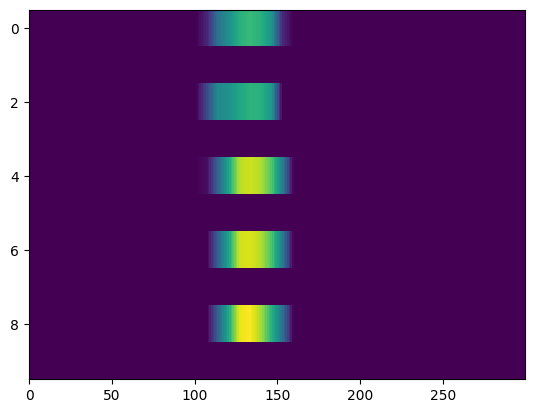

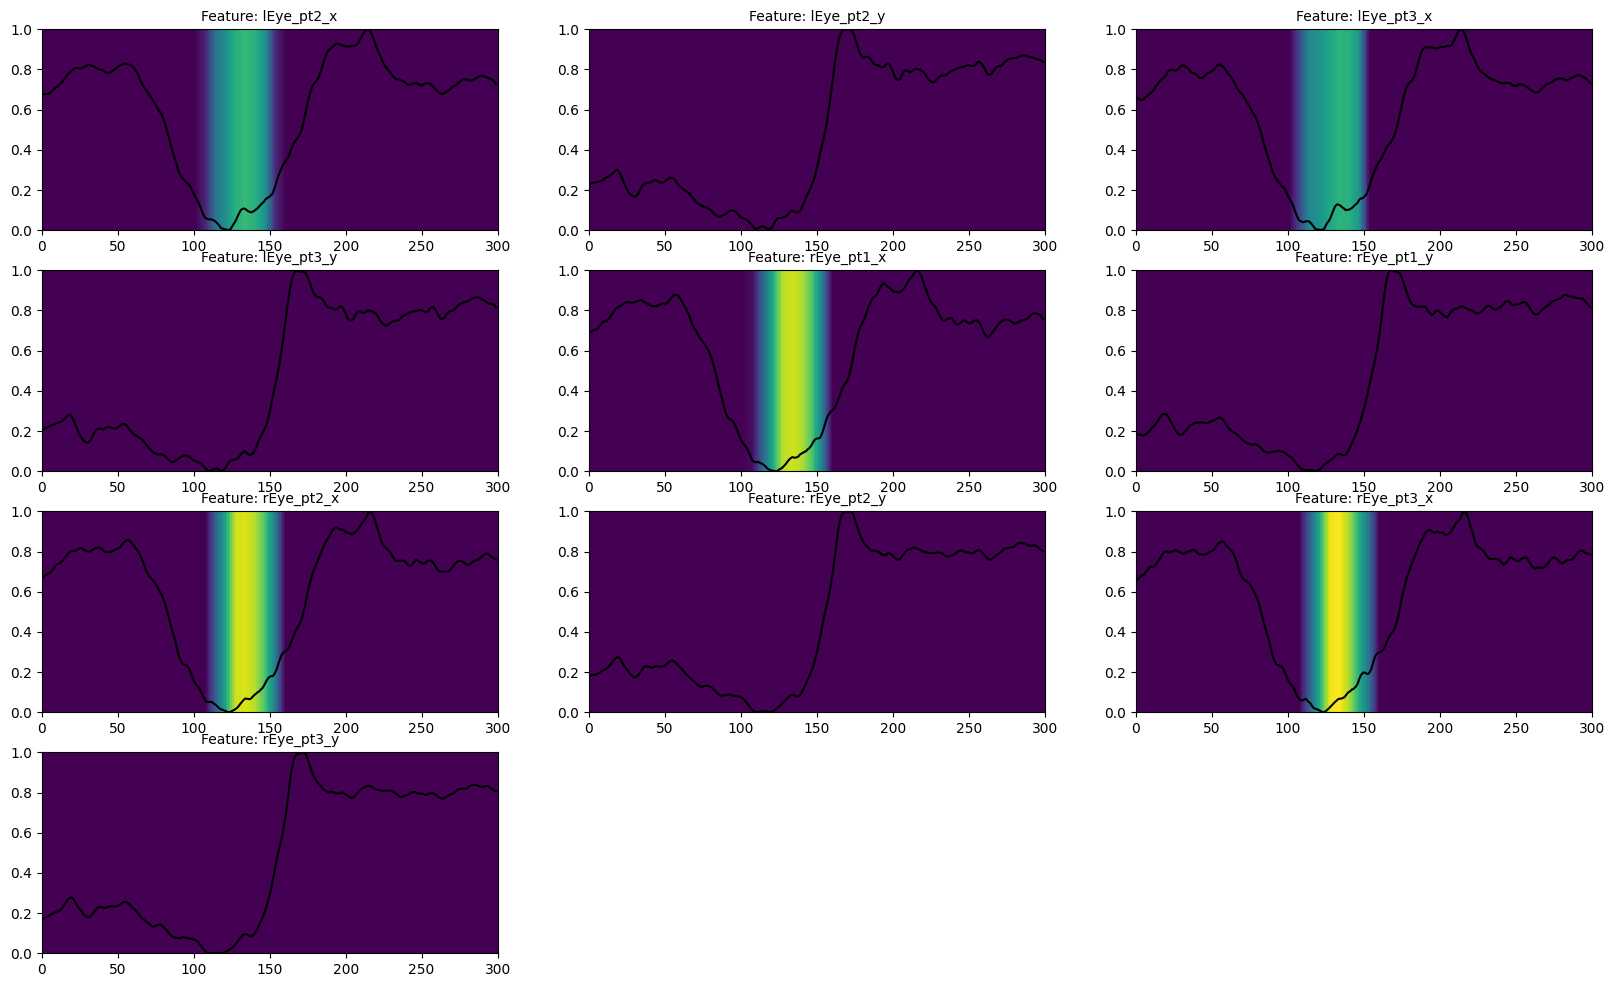

------------------------------- [Pid 65] [Fold 1] Prob: 0.5618000030517578, Segment: 2 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


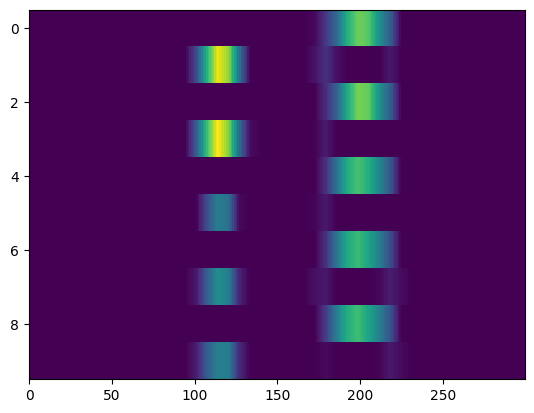

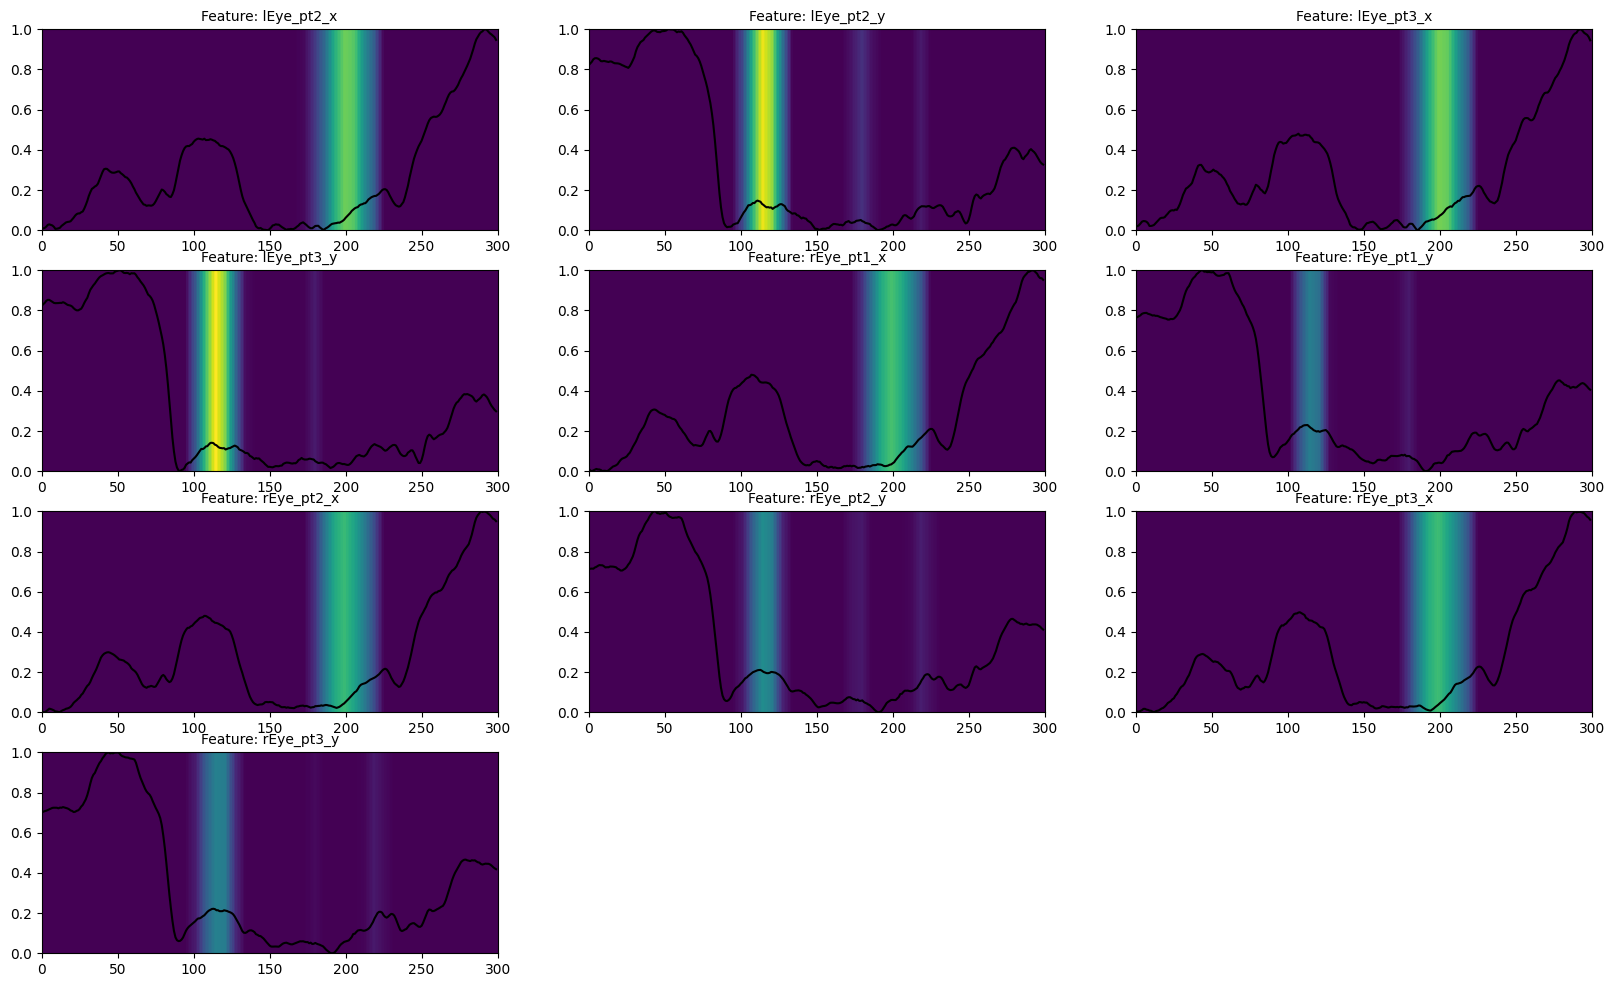

------------------------------- [Pid 65] [Fold 1] Prob: 0.8956000208854675, Segment: 4 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


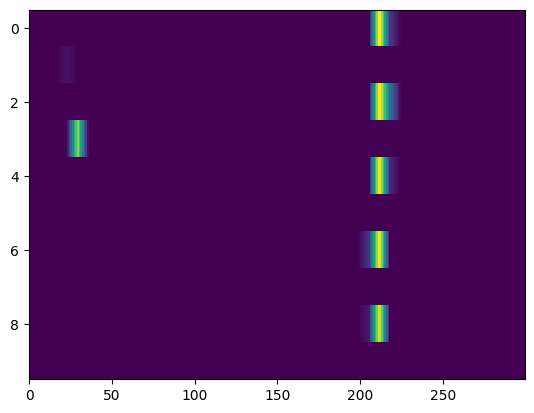

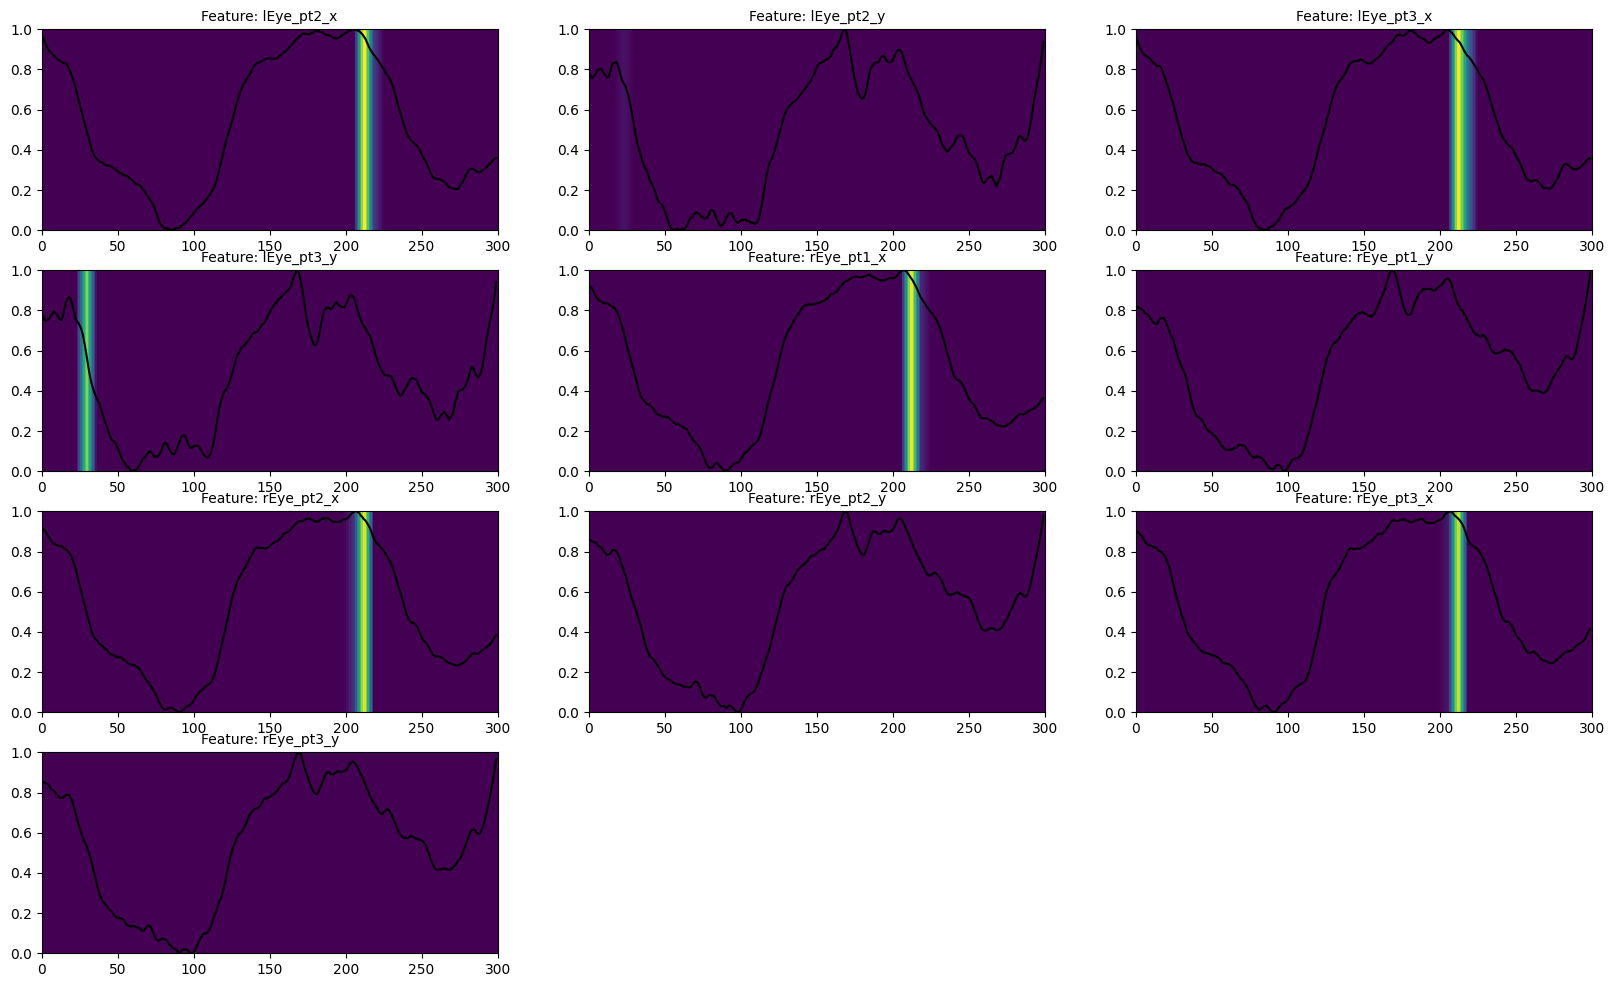

------------------------------- [Pid 65] [Fold 1] Prob: 0.2542000114917755, Segment: 1 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


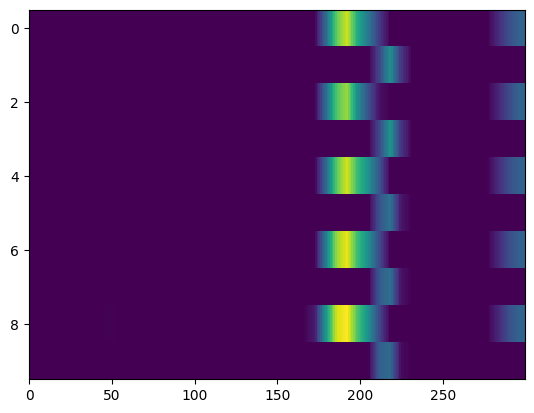

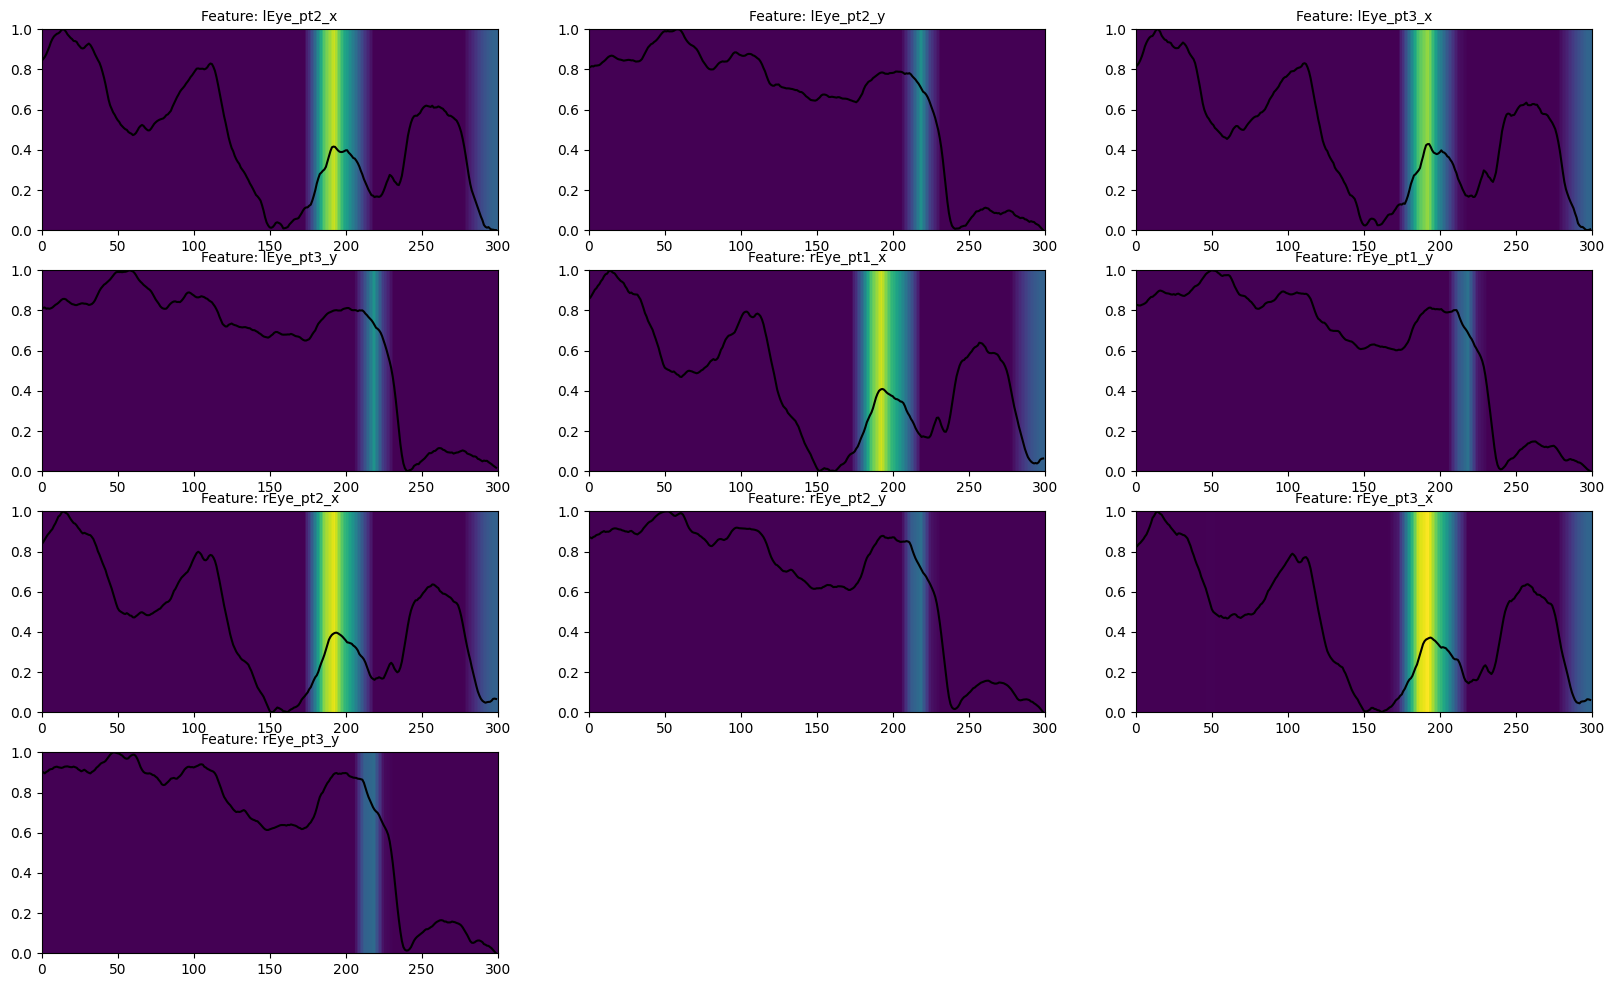

------------------------------- [Pid 65] [Fold 1] Prob: 0.08810000121593475, Segment: 10 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


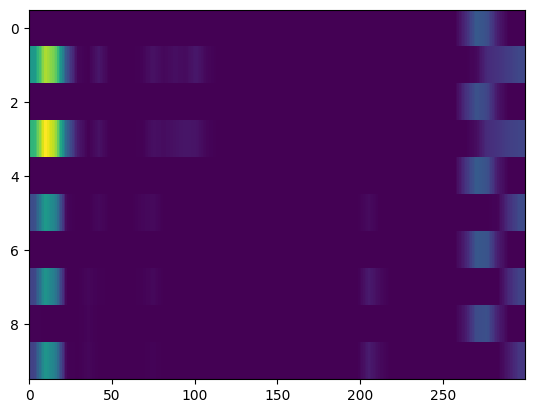

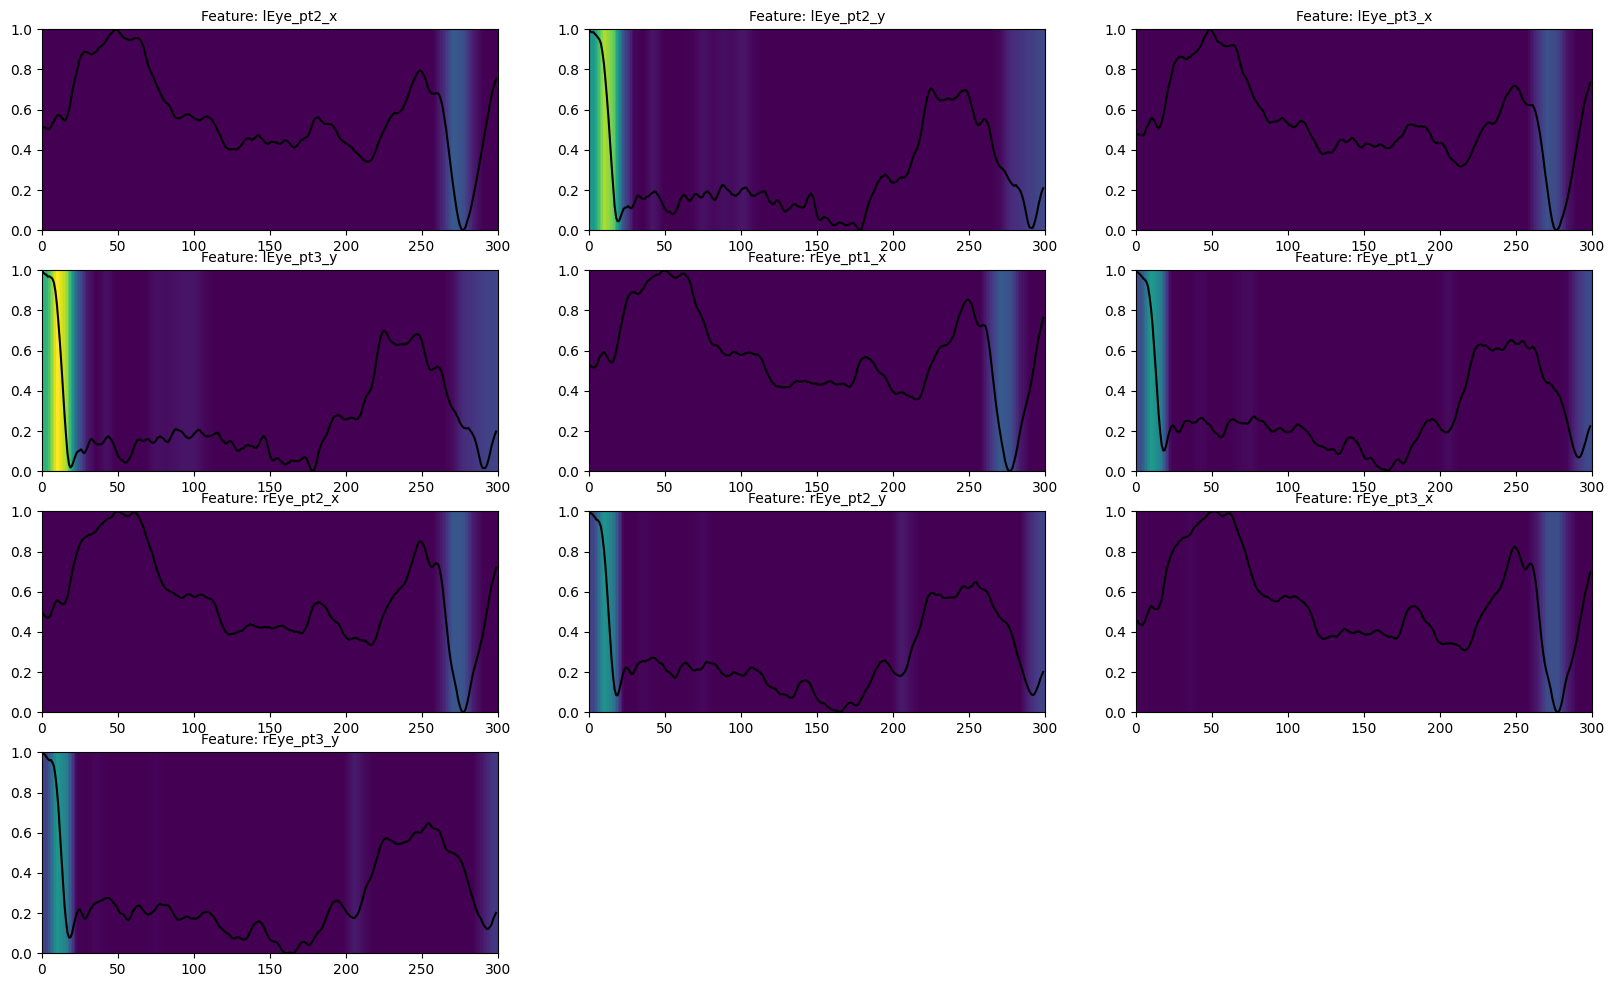

------------------------------- [Pid 65] [Fold 1] Prob: 0.20800000429153442, Segment: 7 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


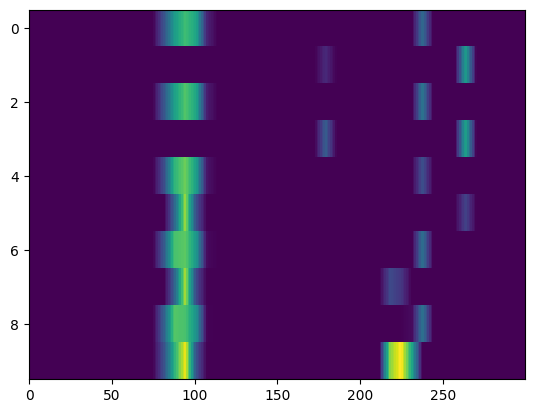

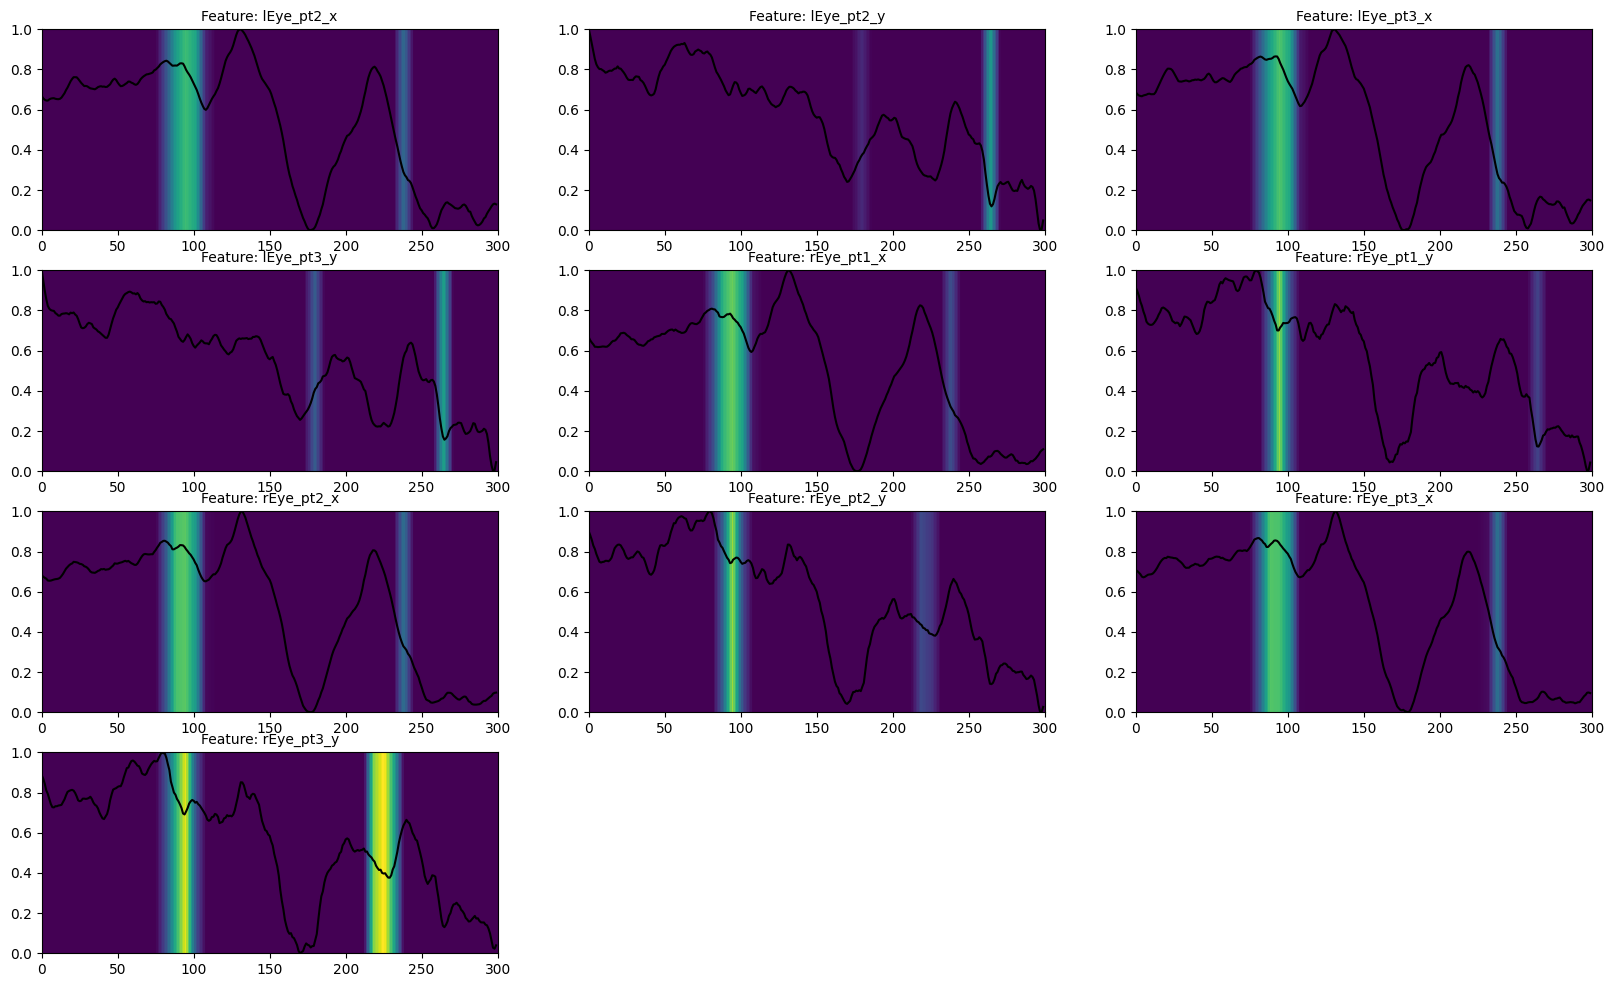

------------------------------- [Pid 65] [Fold 1] Prob: 0.37529999017715454, Segment: 9 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


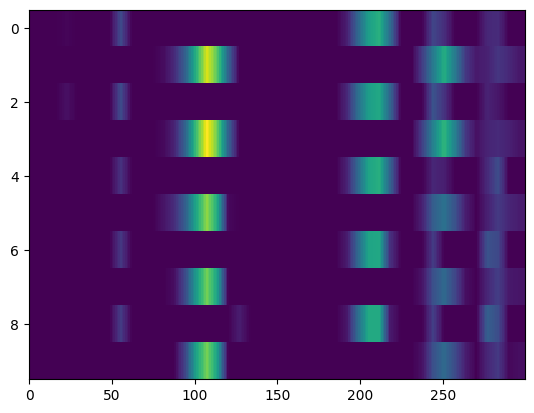

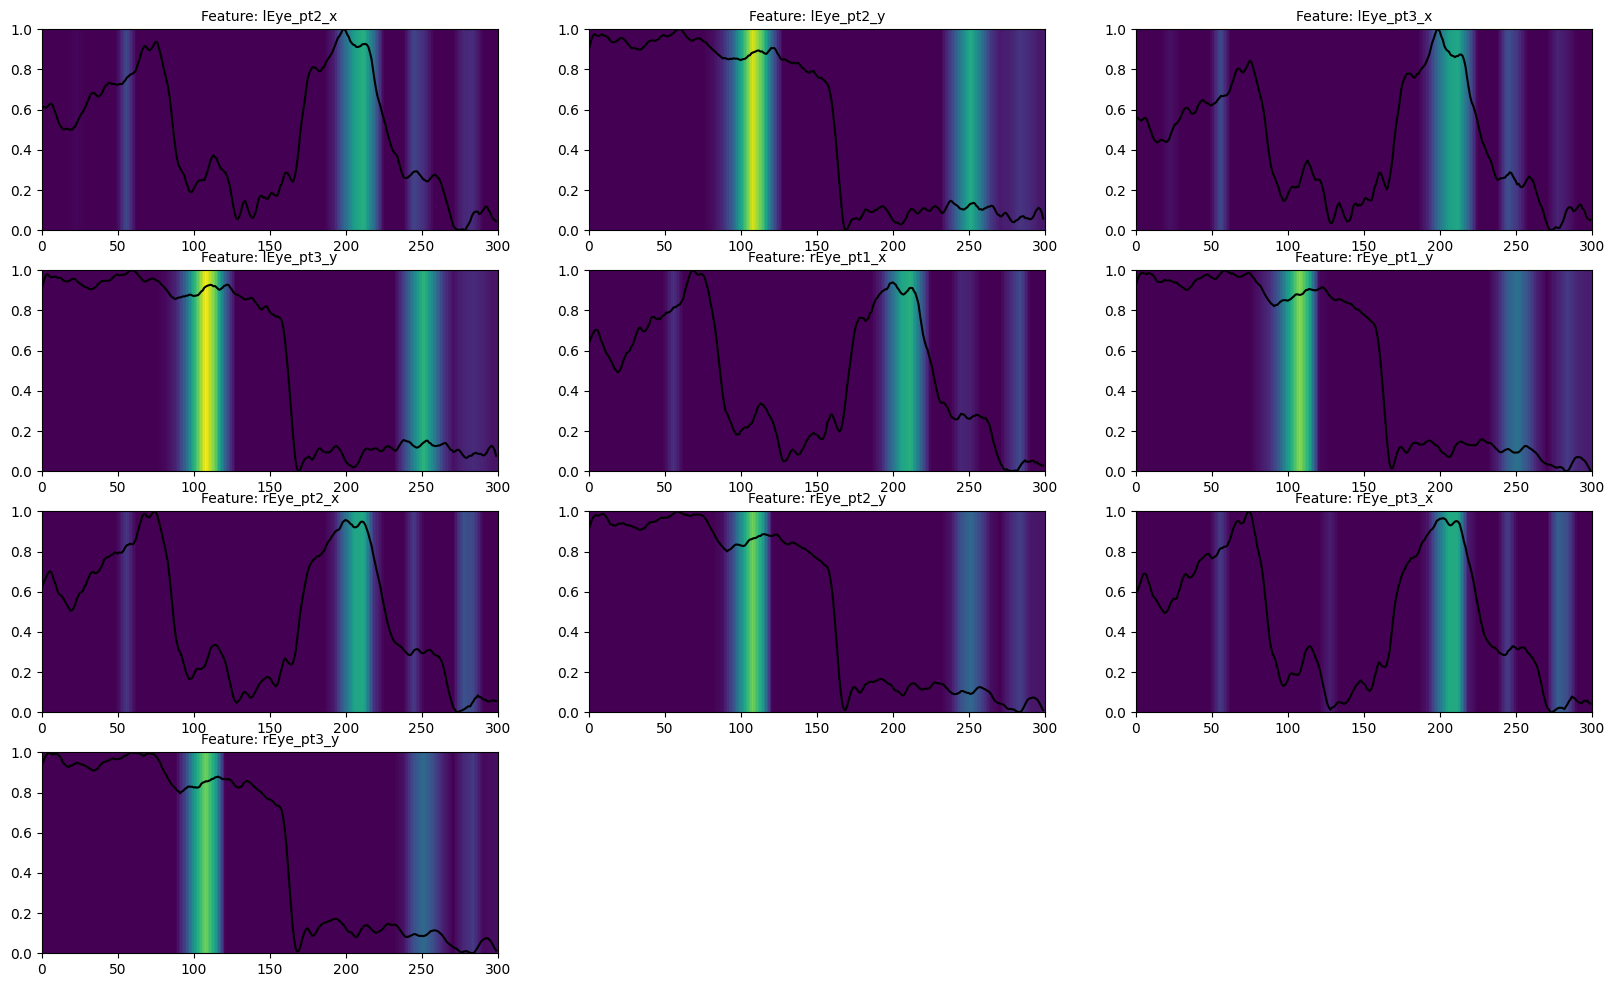

------------------------------- [Pid 65] [Fold 1] Prob: 0.8353000283241272, Segment: 3 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


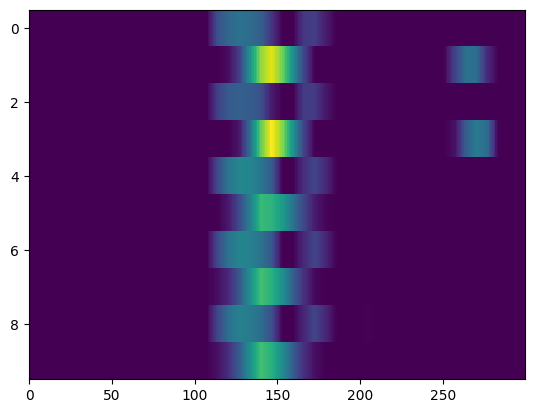

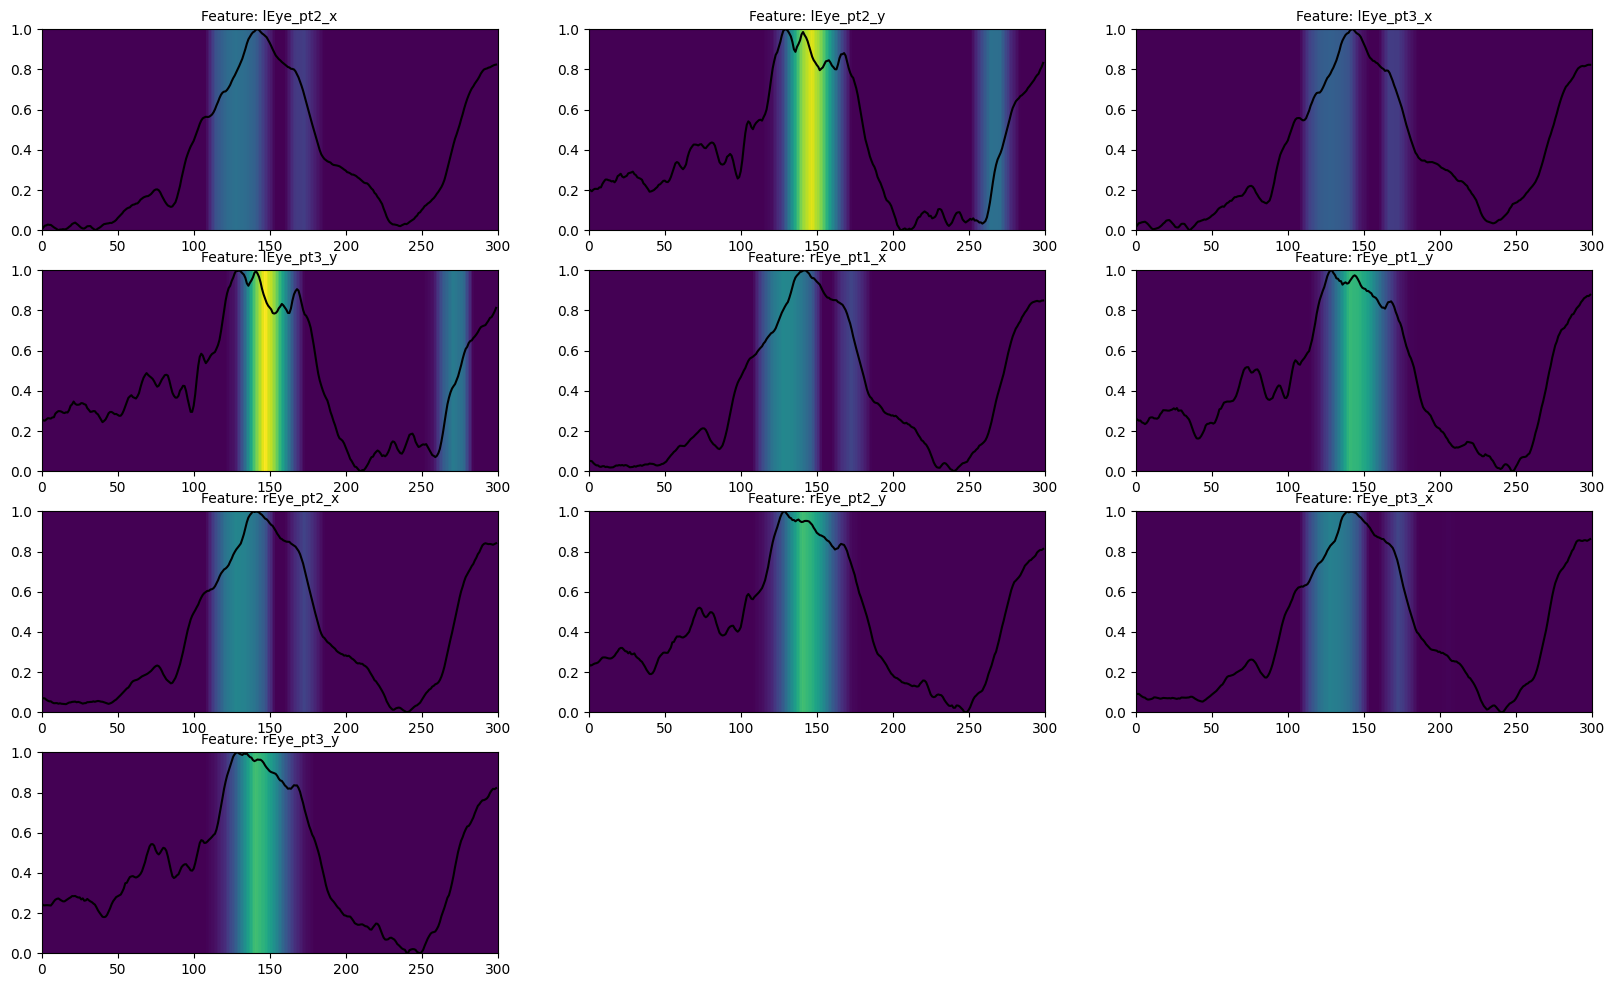

------------------------------- [Pid 65] [Fold 1] Prob: 0.1696999967098236, Segment: 6 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


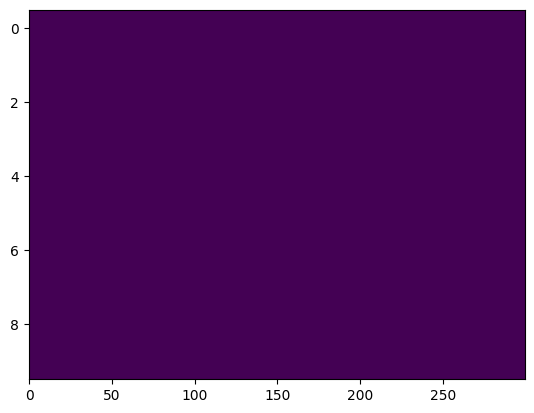

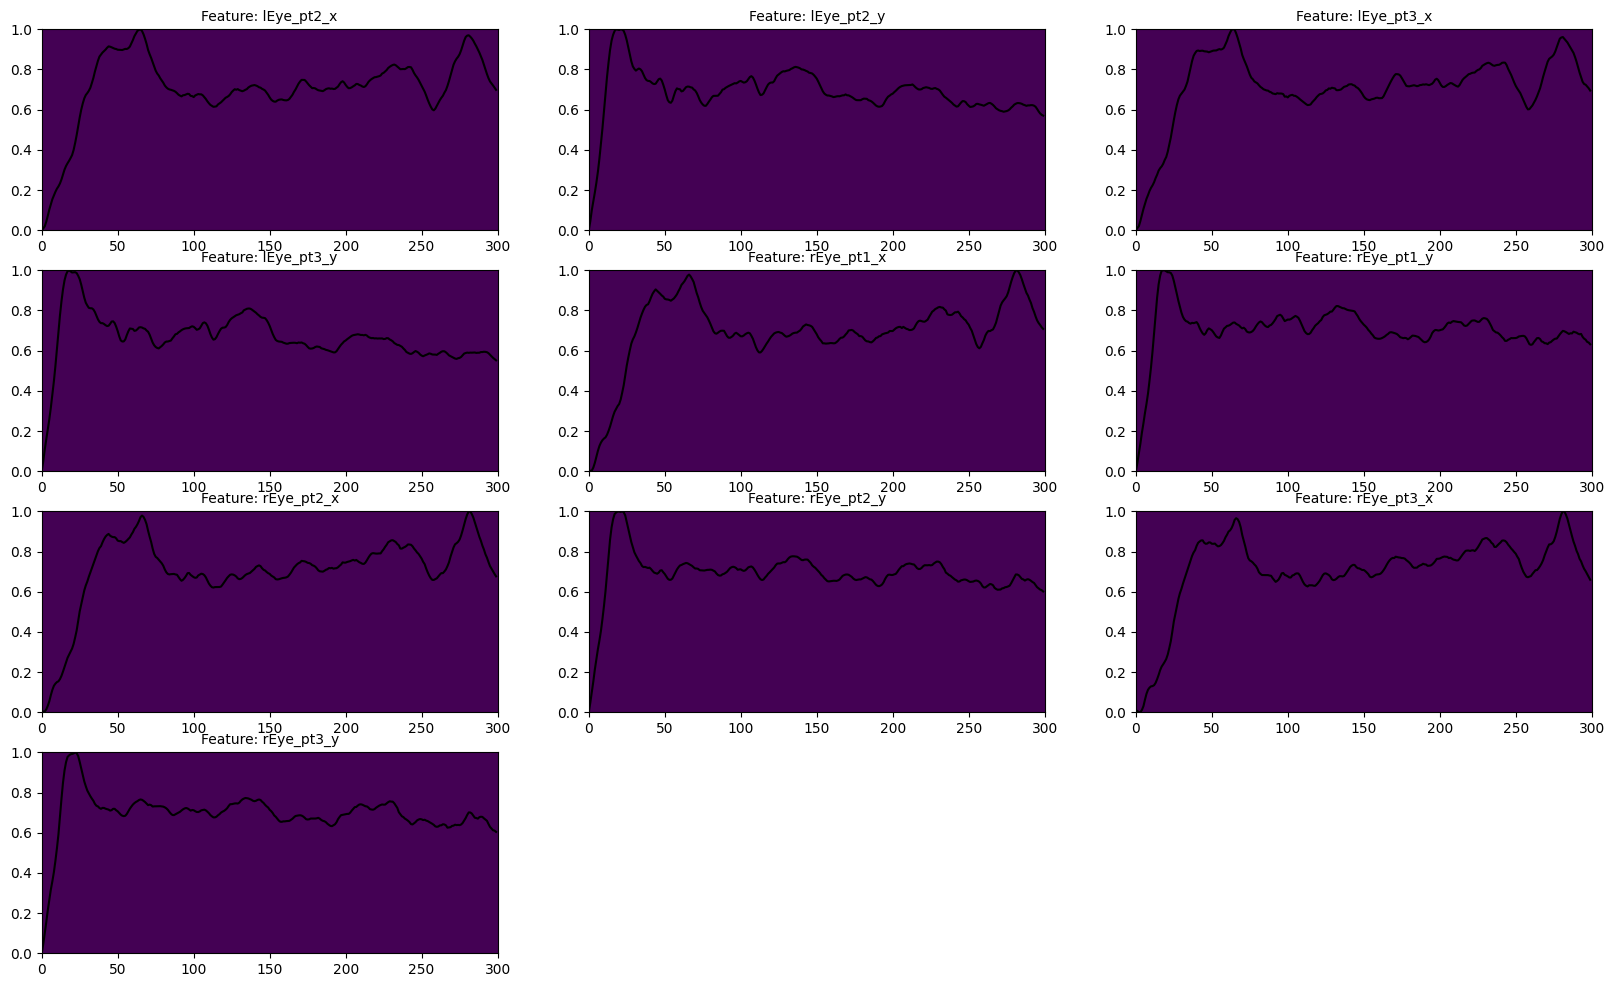

------------------------------- [Pid 65] [Fold 1] Prob: 0.2924000024795532, Segment: 8 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


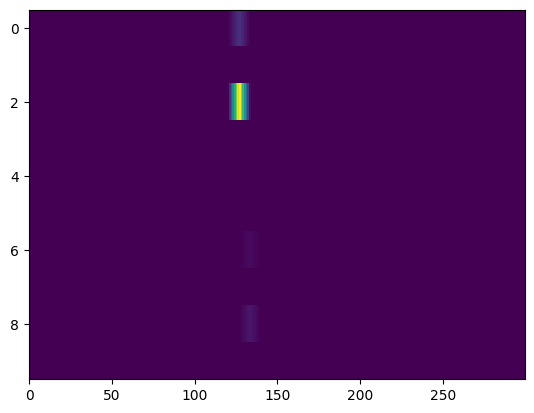

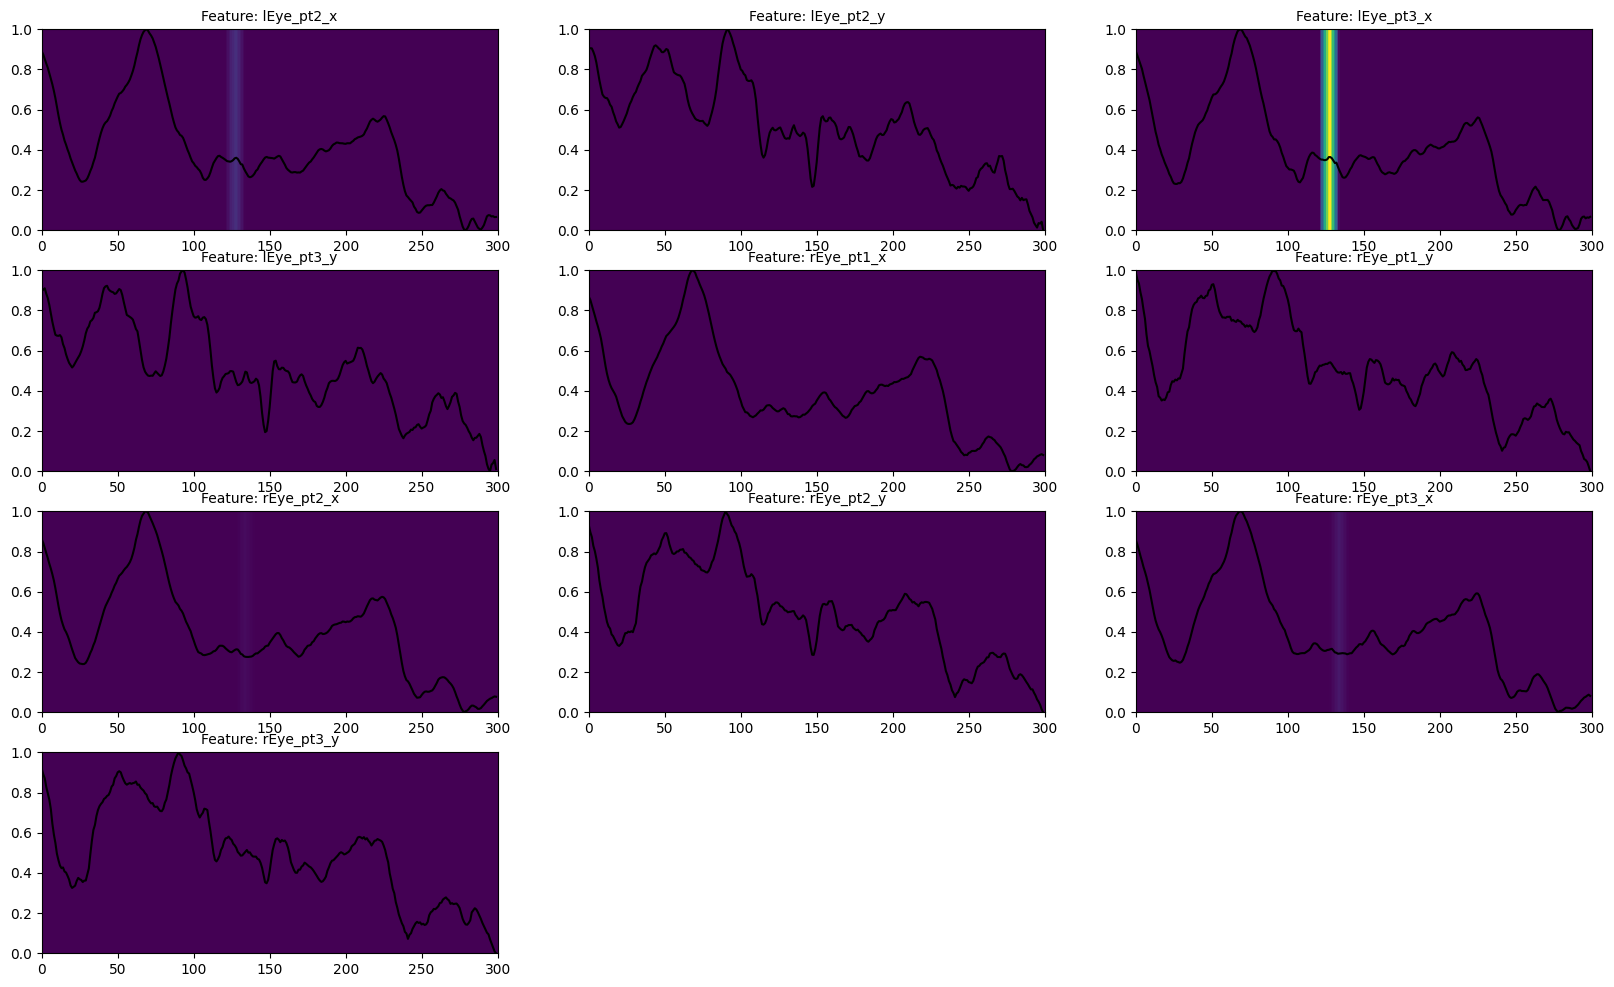

------------------------------- [Pid 65] [Fold 1] Prob: 0.12389999628067017, Segment: 0 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


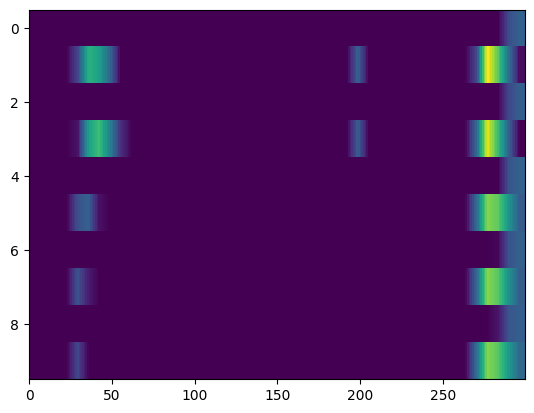

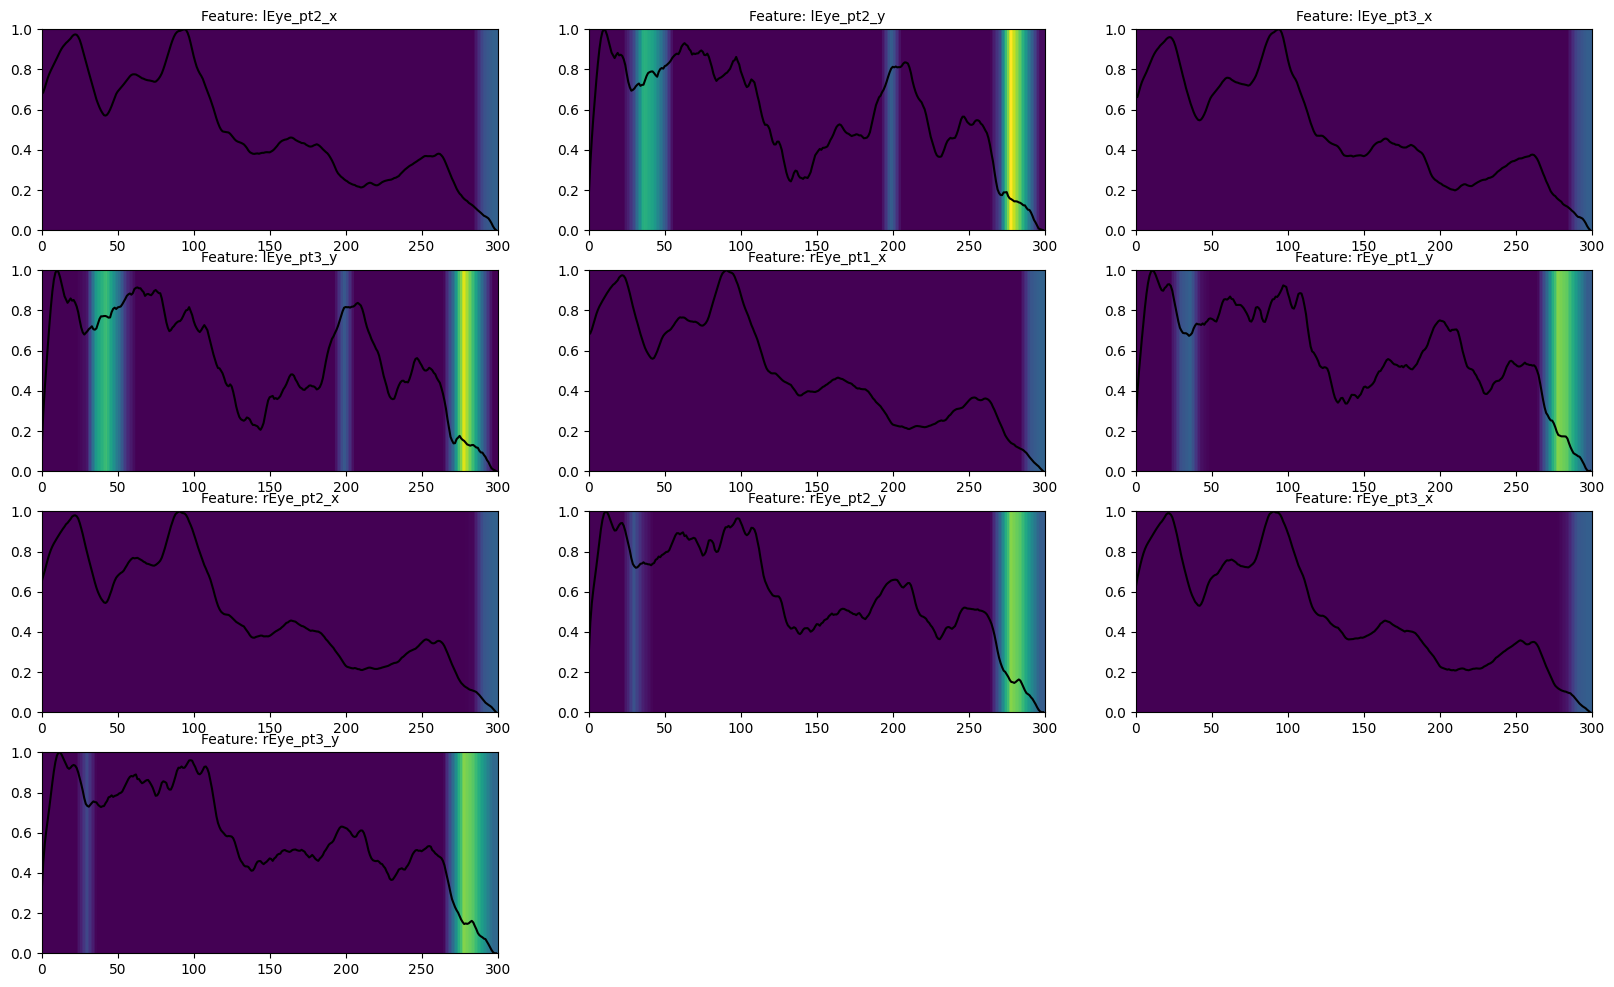

selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']


In [34]:
show_GradCAM_result()
# show_GradCAM_with_higher_confidence()

selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
------------------------------- [Pid 72] [Fold 2] Segment: 0 -------------------------------


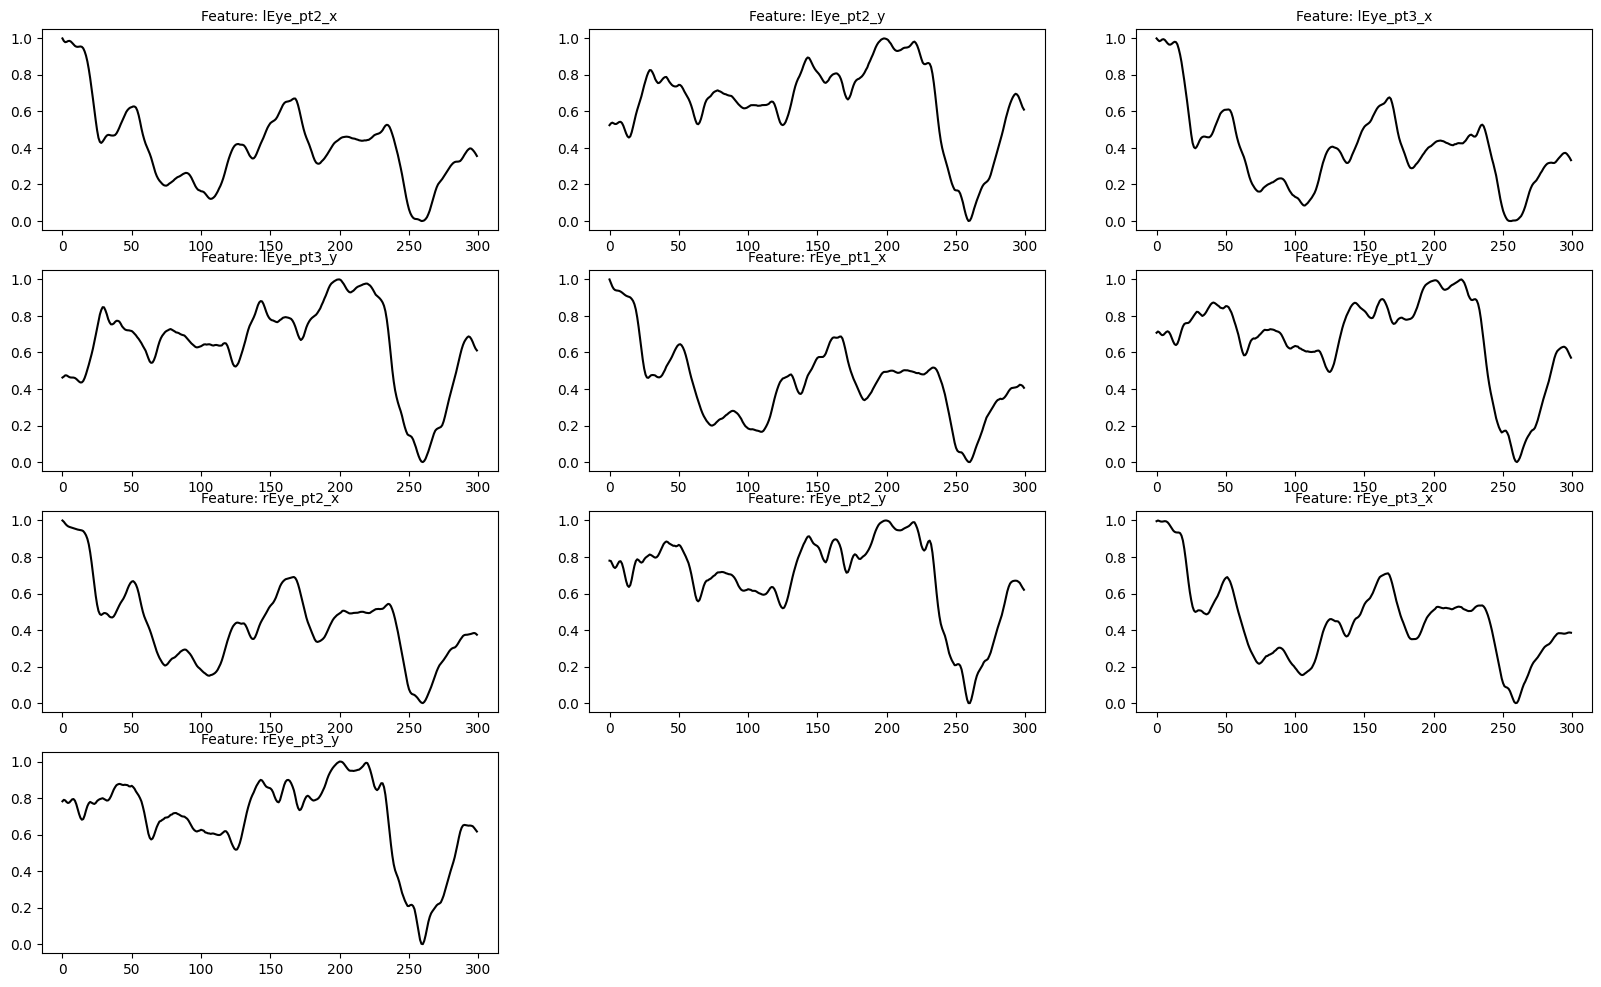

------------------------------- [Pid 72] [Fold 2] Segment: 1 -------------------------------


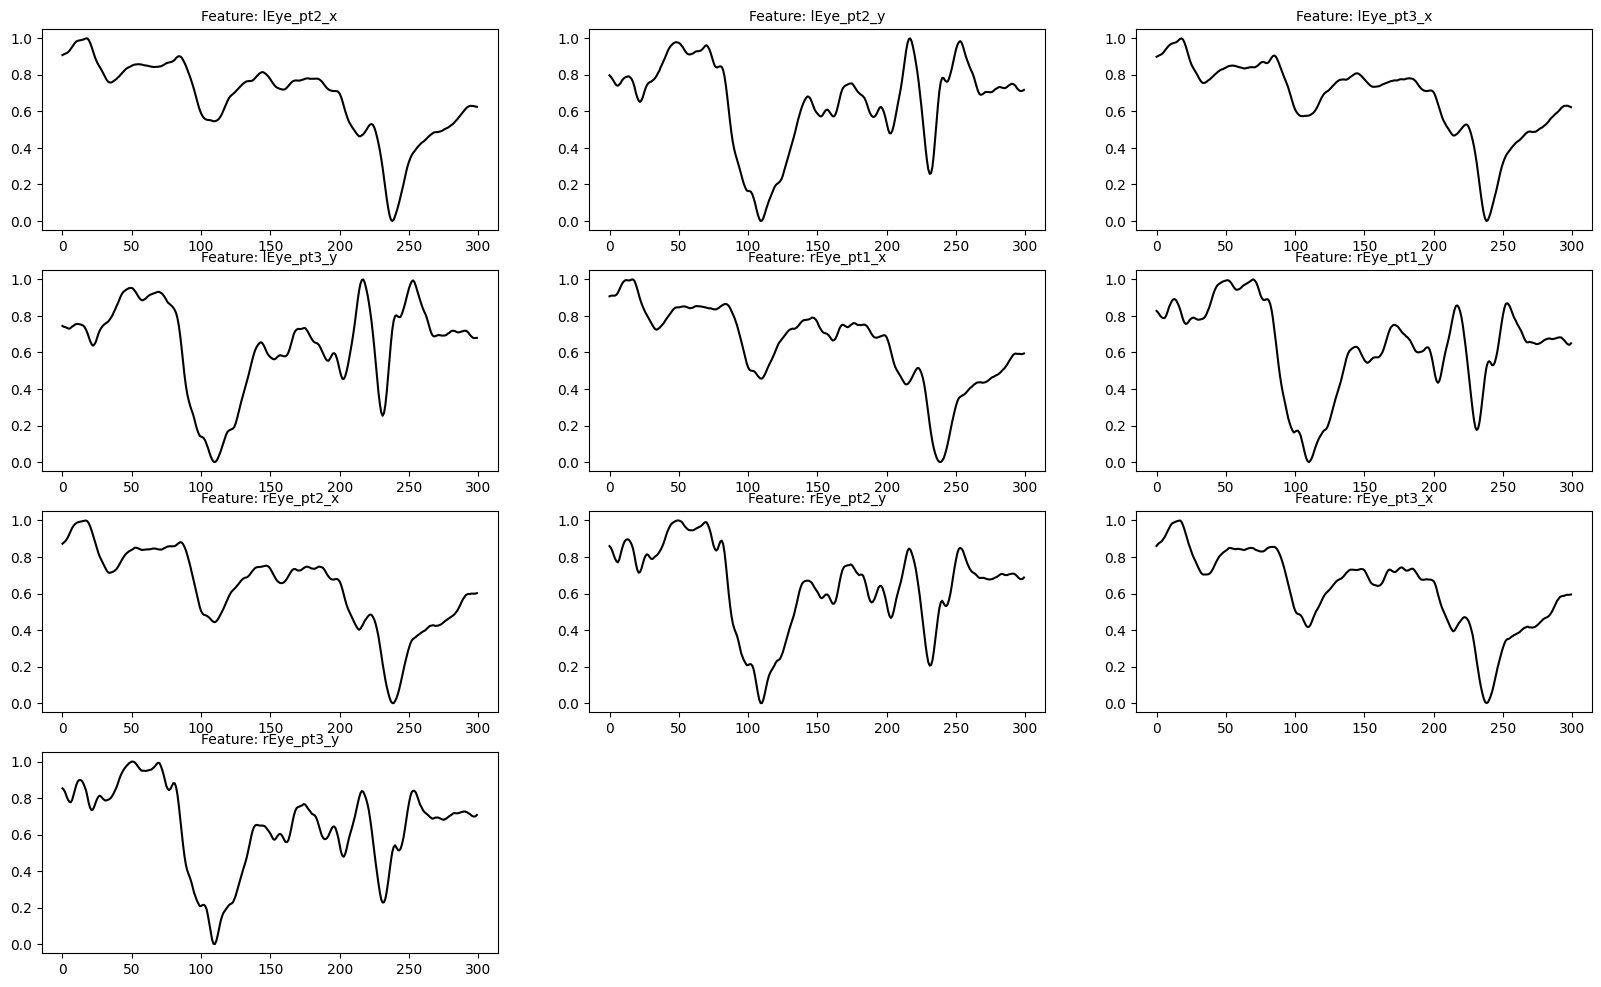

------------------------------- [Pid 72] [Fold 2] Segment: 2 -------------------------------


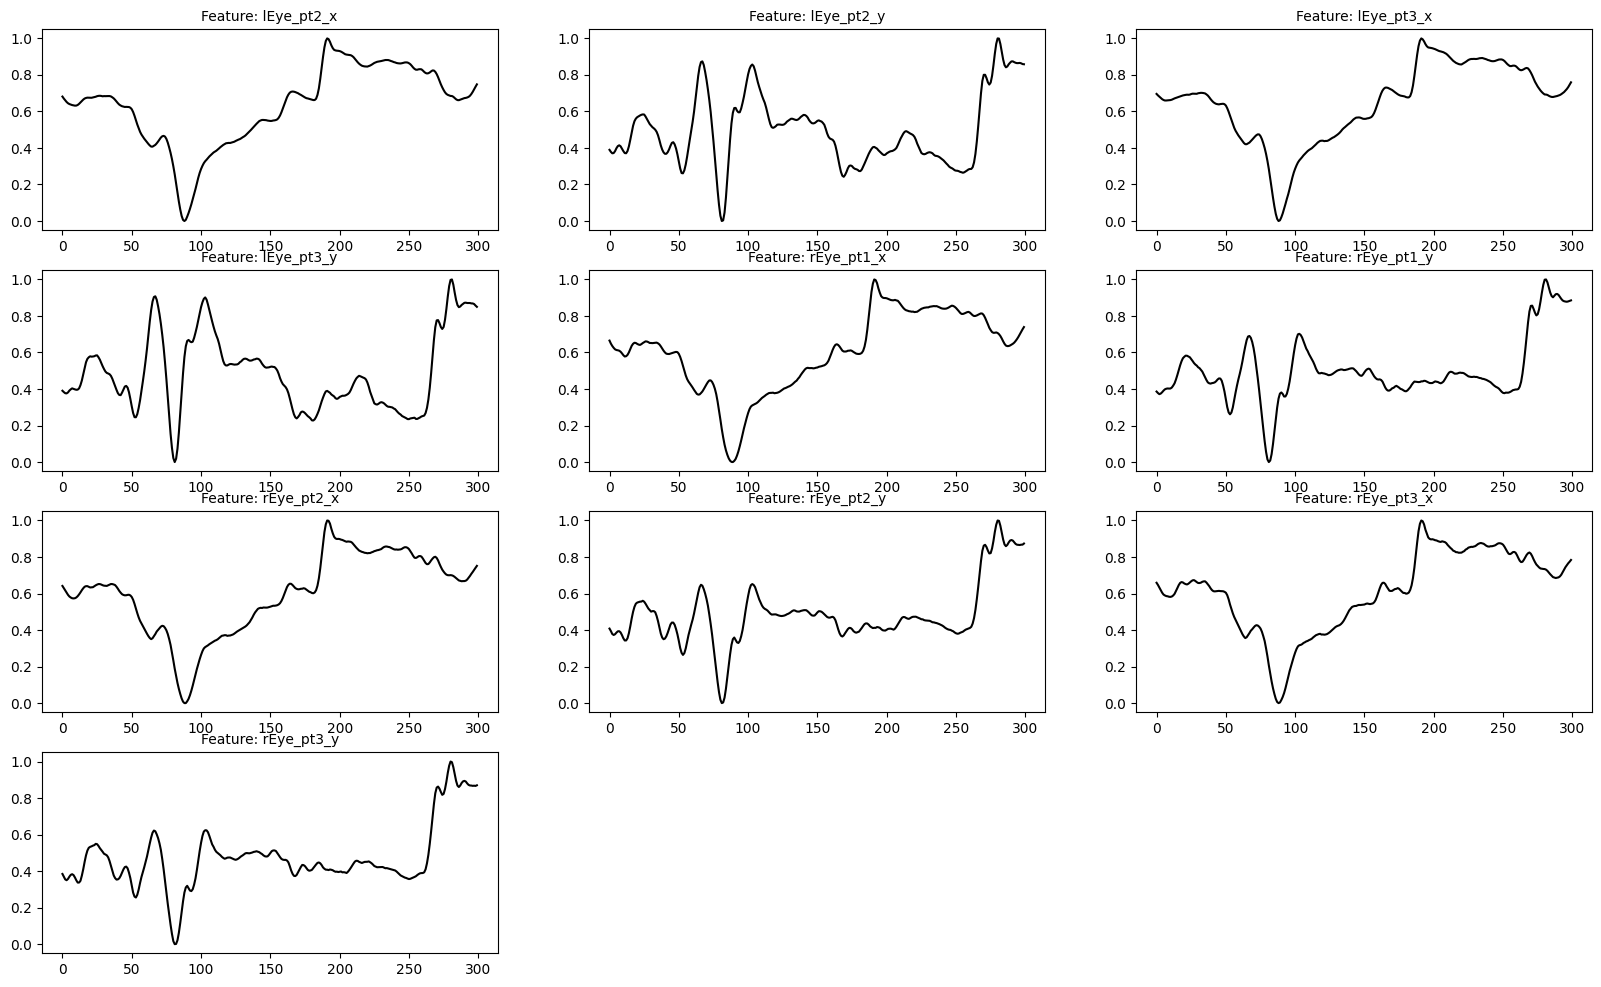

selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']


In [35]:
def draw_feature_selected():
    for fold_idx in range(n_FOLD):
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]

        selected_feature = selected_features

        feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                             'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
        new_feature_name_list = []
        for feat_idx in selected_feature:
            new_feature_name_list.append(feature_name_list[feat_idx])
        print(f'selected_feature: {selected_feature}')
        print(f'new_feature_name_list: {new_feature_name_list}')
        
        for test_idx in range(len(idxTest_1f)):
            cur_pid = idxTest_1f[test_idx]
            segmentIdx = segmentIdx_1f[test_idx]
            if cur_pid==72:
                test_data = xTest_1f[test_idx] ### shape=(12, 50)
                width, height = test_data.shape[1], test_data.shape[0]
                test_data = np.expand_dims(test_data, axis=0) ### shape=(1, 12, 50)

                print(f'------------------------------- [Pid {cur_pid}] [Fold {fold_idx}] Segment: {segmentIdx} -------------------------------')
                
                plt.figure(figsize=(20, 12))
                for featureIdx in range(n_SELECTED_FEATURE):
                    plt.subplot(4, 3, featureIdx + 1)
                    plt.title(f'Feature: {new_feature_name_list[featureIdx]}', fontsize=10)
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show()  
draw_feature_selected()

## Save Grad-CAM to CSV file

In [36]:
result_segment_dict[1]

{'segment_2': 0.0323,
 'segment_7': 0.7953,
 'segment_4': 0.0414,
 'segment_8': 0.9019,
 'segment_3': 0.4192,
 'segment_6': 0.0819,
 'segment_0': 0.3536,
 'segment_1': 0.1988,
 'segment_5': 0.5519}

In [37]:
SAVE_SEGPROB_FOLDER = "LOG_FS/Segment_Probability/"

if not os.path.exists(SAVE_SEGPROB_FOLDER):
    os.makedirs(SAVE_SEGPROB_FOLDER)

In [38]:
### Step 1: Save the probability of each segement into CSV file

def save_segemnt_probability_to_csv(prob_dict, fileName):
    prob_dict_sorted = {}
    myKeys = list(prob_dict.keys())
    myKeys.sort()
    prob_dict_sorted = {i: prob_dict[i] for i in myKeys}

    result_list = []
    for pid in prob_dict_sorted:
        for seg in prob_dict_sorted[pid]:
            seg_number = seg.split('_')[1]
            segName = str(pid) + '_segment_' + str(seg_number)
            prob = prob_dict_sorted[pid][seg]
            result_list.append([segName, prob])
                
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerows(result_list)

save_segemnt_probability_to_csv(result_segment_dict, SAVE_SEGPROB_FOLDER+'seg_probability.csv')

In [39]:
SAVE_GradCAM_FOLDER = "LOG_FS/GradCAM_heatmap/"

if not os.path.exists(SAVE_GradCAM_FOLDER):
    os.makedirs(SAVE_GradCAM_FOLDER)

In [40]:
### Step 2 : Save Grad-CAM heatmap into CSV file


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def get_feature_name_list(selected_feature):
    new_feature_name_list = []
    
    feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                         'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']

    for feat_idx in selected_feature:
        new_feature_name_list.append(feature_name_list[feat_idx])
    print(f'selected_feature: {selected_feature}')
    print(f'new_feature_name_list: {new_feature_name_list}')
    return new_feature_name_list


def save_GradCAM_to_CSV_file():
    feature_name_list = get_feature_name_list(selected_features)
    
    for fold_idx in range(n_FOLD):
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]

        for test_idx in range(len(idxTest_1f)):
            cur_pid = idxTest_1f[test_idx]
            segmentIdx = segmentIdx_1f[test_idx]
            vType = videoType_dict[int(cur_pid)]

            label = Label_dict[int(cur_pid)]
            pred_average = result_dict[cur_pid]["prediction"]
            pred_weighted = result_weighted_dict[cur_pid]["prediction"]

            # if cur_pid==62:
            test_data = xTest_1f[test_idx]
            width, height = test_data.shape[1], test_data.shape[0]
            test_data = np.expand_dims(test_data, axis=0) ### shape=(1, 12, 50)

            filename = SAVE_GradCAM_FOLDER + str(cur_pid) + '_Segment' + str(segmentIdx) + '.csv'  # "37_Segment1.csv"
            
            heatmap = make_gradcam_heatmap(test_data, model, 'last_conv')
            heatmap = np.uint8(255*heatmap)
            heatmap_df = pd.DataFrame(heatmap)
            heatmap_df.index = feature_name_list
            heatmap_df.to_csv(filename, header=False)

            # plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)                
            # plt.show()


save_GradCAM_to_CSV_file()

selected_feature: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']


## Write to CSV file

In [34]:
def write_result_to_csv(data_dict, data_name, fileName):
    print(f'------ {data_name}: -------\n')
    data_dict_sorted = {}
    myKeys = list(data_dict.keys())
    myKeys.sort()
    data_dict_sorted = {i: data_dict[i] for i in myKeys}
    print(f'Number of subjects: {len(data_dict_sorted)} subjects.\n')
    # print(data_dict_sorted)
    
    result_list = []
    for key in data_dict_sorted:
        v1 = key
        v2 = data_dict_sorted[key]["avegProb"]
        v3 = data_dict_sorted[key]["prediction"]
        v4 = data_dict_sorted[key]["actual"]
        result_list.append([v1, v2, v3, v4])
        
    field_name = ['pid', 'avgProb', 'prediction', 'actual']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)
    return data_dict_sorted

In [35]:
#[RandomSeed]
result_csv_filename = "LOG_FS/Facial_RandomSeed/Results/" + str(seed_value) + "_FS_average.csv"
result_dict_sorted = write_result_to_csv(result_dict, "result_dict", result_csv_filename) 
result_dict_sorted

------ result_dict: -------

Number of subjects: 96 subjects.



{1: {'avegProb': 0.3963, 'n_pairs': 9, 'prediction': 0, 'actual': 0},
 2: {'avegProb': 0.5486, 'n_pairs': 6, 'prediction': 1, 'actual': 0},
 3: {'avegProb': 0.4588, 'n_pairs': 5, 'prediction': 1, 'actual': 0},
 4: {'avegProb': 0.2132, 'n_pairs': 6, 'prediction': 0, 'actual': 1},
 5: {'avegProb': 0.256, 'n_pairs': 9, 'prediction': 0, 'actual': 0},
 6: {'avegProb': 0.4599, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 7: {'avegProb': 0.3773, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 8: {'avegProb': 0.5052, 'n_pairs': 2, 'prediction': 1, 'actual': 0},
 9: {'avegProb': 0.0875, 'n_pairs': 2, 'prediction': 0, 'actual': 1},
 10: {'avegProb': 0.2357, 'n_pairs': 3, 'prediction': 0, 'actual': 1},
 11: {'avegProb': 0.3625, 'n_pairs': 2, 'prediction': 0, 'actual': 1},
 12: {'avegProb': 0.2946, 'n_pairs': 6, 'prediction': 0, 'actual': 1},
 13: {'avegProb': 0.2913, 'n_pairs': 23, 'prediction': 0, 'actual': 0},
 14: {'avegProb': 0.1841, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 15: {'avegProb

In [36]:
def write_weighted_result_to_csv(data_dict, data_name, fileName):
    print(f'------- {data_name}: -------\n')
    data_dict_sorted = {}
    myKeys = list(data_dict.keys())
    myKeys.sort()
    data_dict_sorted = {i: data_dict[i] for i in myKeys}
    print(f'Number of subjects: {len(data_dict_sorted)} subjects.\n')
    # print(data_dict_sorted)
    
    result_list = []
    for key in data_dict_sorted:
        v1 = key
        v2 = data_dict_sorted[key]["avegProb_weighted"]
        v3 = data_dict_sorted[key]["prediction"]
        v4 = data_dict_sorted[key]["actual"]
        result_list.append([v1, v2, v3, v4])
    field_name = ['pid', 'avgProb', 'prediction', 'actual']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)
    return data_dict_sorted

In [38]:
#[RandomSeed]
result_weighted_csv_filename = "LOG_FS/Facial_RandomSeed/Results/" + str(seed_value) + "_FS_weighted.csv"
result_weighted_dict_sorted = write_weighted_result_to_csv(result_weighted_dict, "result_weighted_dict", result_weighted_csv_filename)
result_weighted_dict_sorted

------- result_weighted_dict: -------

Number of subjects: 96 subjects.



{1: {'avegProb_weighted': 0.1196, 'prediction': 0, 'actual': 0},
 2: {'avegProb_weighted': 0.4328, 'prediction': 1, 'actual': 0},
 3: {'avegProb_weighted': 0.3274, 'prediction': 0, 'actual': 0},
 4: {'avegProb_weighted': 0.2708, 'prediction': 0, 'actual': 1},
 5: {'avegProb_weighted': 0.1899, 'prediction': 0, 'actual': 0},
 6: {'avegProb_weighted': 0.4548, 'prediction': 0, 'actual': 0},
 7: {'avegProb_weighted': 0.2388, 'prediction': 0, 'actual': 0},
 8: {'avegProb_weighted': 0.4685, 'prediction': 1, 'actual': 0},
 9: {'avegProb_weighted': 0.1271, 'prediction': 0, 'actual': 1},
 10: {'avegProb_weighted': 0.281, 'prediction': 0, 'actual': 1},
 11: {'avegProb_weighted': 0.4063, 'prediction': 0, 'actual': 1},
 12: {'avegProb_weighted': 0.3376, 'prediction': 0, 'actual': 1},
 13: {'avegProb_weighted': 0.1865, 'prediction': 0, 'actual': 0},
 14: {'avegProb_weighted': 0.1195, 'prediction': 0, 'actual': 0},
 15: {'avegProb_weighted': 0.355, 'prediction': 0, 'actual': 0},
 16: {'avegProb_weigh

# Metrics (5 folds)
* Accuracy
* Sensitivity
* Specificity
* Precision
* F1-Score
* AUC

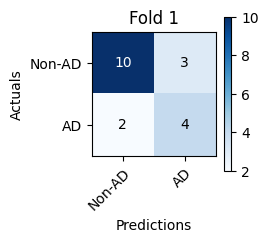

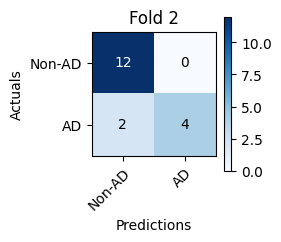

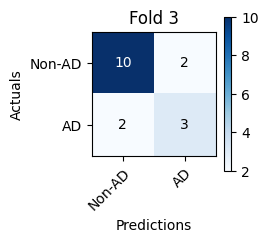

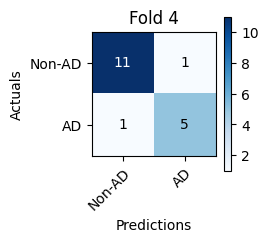

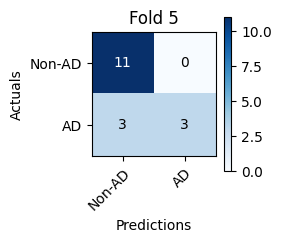

In [39]:
metrics_5fold_dict = {}

def load_model_and_evaluate_five_folds_metrics():
    metrics_5fold_dict = {}
    
    for fold_idx in range(n_FOLD):
        testID = testID_5f[fold_idx]
        yPred, yTrue = [], []
        predict_label_weighted_List, actual_label_weighted_List = [], []
        for pid in testID:
            pid = int(pid)
            prob = result_weighted_dict[pid]['avegProb_weighted']
            predict_label = result_weighted_dict[pid]['prediction']
            label = Label_dict[pid]
            yPred.append(prob)
            yTrue.append(label)
            predict_label_weighted_List.append(predict_label)
            actual_label_weighted_List.append(label)
            
        predict_label_weighted_array = np.array(predict_label_weighted_List)
        actual_label_weighted_array = np.array(actual_label_weighted_List)
        matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
        TN, FP, FN, TP = matrix.ravel()
        value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
        value_sensitivity = round(TP/(TP+FN), 4)
        value_specificity = round(TN/(TN+FP), 4)
        value_precision = round(TP/(TP+FP), 4)
        value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
        auc = roc_auc_score(yTrue, yPred)
        
        classList = ['Non-AD', 'AD']
        matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
        TN, FP, FN, TP = matrix.ravel()
        fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(2, 2), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
        plt.xlabel('Predictions', fontsize=10)
        plt.ylabel('Actuals', fontsize=10)
        plt.title(f'Fold {fold_idx+1}', fontsize=12)
        plt.show()
        
        
        metrics_5fold_dict[fold_idx] = {}
        metrics_5fold_dict[fold_idx]['AUC'] = round(auc, 4)
        metrics_5fold_dict[fold_idx]['Accuracy'] = value_accuracy
        metrics_5fold_dict[fold_idx]['Sensitivity'] = value_sensitivity
        metrics_5fold_dict[fold_idx]['Specificity'] = value_specificity
        metrics_5fold_dict[fold_idx]['Precision'] = value_precision
        metrics_5fold_dict[fold_idx]['F1-Score'] = value_f1_score
        
    return metrics_5fold_dict


metrics_5fold_dict = load_model_and_evaluate_five_folds_metrics()

In [40]:
acc_5f, auc_5f, sen_5f, spe_5f, pre_5f, f1_5f = [], [], [], [], [], []
for fold_idx in range(n_FOLD):
    one_fold_metrics = metrics_5fold_dict[fold_idx]
    acc = one_fold_metrics['Accuracy']
    auc = one_fold_metrics['AUC']
    sen = one_fold_metrics['Sensitivity']
    spe = one_fold_metrics['Specificity']
    pre = one_fold_metrics['Precision']
    f1score = one_fold_metrics['F1-Score']
    print(f'[Fold {fold_idx+1}] Accuracy: {acc}, Sensitivity: {sen}, Specificity: {spe}, Precision: {pre}, F1-score: {f1score}, AUC: {auc}')
    
    acc_5f.append(round(acc*100, 2))
    auc_5f.append(auc)
    sen_5f.append(round(sen*100, 2))
    spe_5f.append(round(spe*100, 2))
    pre_5f.append(round(pre*100, 2))
    f1_5f.append(f1score)

[Fold 1] Accuracy: 0.7368, Sensitivity: 0.6667, Specificity: 0.7692, Precision: 0.5714, F1-score: 0.62, AUC: 0.9103
[Fold 2] Accuracy: 0.8889, Sensitivity: 0.6667, Specificity: 1.0, Precision: 1.0, F1-score: 0.8, AUC: 0.9028
[Fold 3] Accuracy: 0.7647, Sensitivity: 0.6, Specificity: 0.8333, Precision: 0.6, F1-score: 0.6, AUC: 0.8333
[Fold 4] Accuracy: 0.8889, Sensitivity: 0.8333, Specificity: 0.9167, Precision: 0.8333, F1-score: 0.83, AUC: 0.9167
[Fold 5] Accuracy: 0.8235, Sensitivity: 0.5, Specificity: 1.0, Precision: 1.0, F1-score: 0.67, AUC: 0.803


In [41]:
from scipy import stats
import statistics

print(f'Accuracy    ({len(acc_5f)}), mean({round(statistics.mean(acc_5f), 2)}), std({round(statistics.pstdev(acc_5f), 2)}): {acc_5f}')
print(f'Sensitivity ({len(sen_5f)}), mean({round(statistics.mean(sen_5f), 2)}), std({round(statistics.pstdev(sen_5f), 2)}): {sen_5f}')
print(f'Specificity ({len(spe_5f)}), mean({round(statistics.mean(spe_5f), 2)}), std({round(statistics.pstdev(spe_5f), 2)}): {spe_5f}')
print(f'Precision   ({len(pre_5f)}), mean({round(statistics.mean(pre_5f), 2)}), std({round(statistics.pstdev(pre_5f), 2)}): {pre_5f}')
print(f'F1-Score    ({len(f1_5f)}), mean({round(statistics.mean(f1_5f), 2)}), std({round(statistics.pstdev(f1_5f), 2)}): {f1_5f}')
print(f'AUC         ({len(auc_5f)}), mean({round(statistics.mean(auc_5f), 2)}), std({round(statistics.pstdev(auc_5f), 2)}): {auc_5f}')

Accuracy    (5), mean(82.06), std(6.24): [73.68, 88.89, 76.47, 88.89, 82.35]
Sensitivity (5), mean(65.33), std(10.87): [66.67, 66.67, 60.0, 83.33, 50.0]
Specificity (5), mean(90.38), std(9.14): [76.92, 100.0, 83.33, 91.67, 100.0]
Precision   (5), mean(80.09), std(18.62): [57.14, 100.0, 60.0, 83.33, 100.0]
F1-Score    (5), mean(0.7), std(0.09): [0.62, 0.8, 0.6, 0.83, 0.67]
AUC         (5), mean(0.87), std(0.05): [0.9103, 0.9028, 0.8333, 0.9167, 0.803]


# Tracks

In [45]:
import operator

In [61]:
CN_score_dict = {}

CN_average_result_list = []
CN_average_confidence_list = []
CN_average_probability_list = []

CN_weighted_result_list = []
CN_weighted_confidence_list = []
CN_weighted_probability_list = []

for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_dict_sorted[pid]['avegProb']
        prediction = result_dict_sorted[pid]['prediction']
        actual = result_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==0 and prediction==actual:
            CN_average_result_list.append([pid, prob, conf])
            
CN_average_confidence_list = sorted(CN_average_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
CN_average_probability_list = sorted(CN_average_result_list, key=operator.itemgetter(1))                ### Probability



for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
        prediction = result_weighted_dict_sorted[pid]['prediction']
        actual = result_weighted_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==0 and prediction==actual:
            CN_weighted_result_list.append([pid, prob, conf])
            
CN_weighted_confidence_list = sorted(CN_weighted_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
CN_weighted_probability_list = sorted(CN_weighted_result_list, key=operator.itemgetter(1))              ### Probability


for i, data in enumerate(CN_average_probability_list):
    pid = data[0]
    if pid not in CN_score_dict: CN_score_dict[pid] = 0
    CN_score_dict[pid] += i

# for i, data in enumerate(CN_weighted_confidence_list):
#     pid = data[0]
#     if pid not in CN_score_dict: CN_score_dict[pid] = 0
#     CN_score_dict[pid] += i

for i, data in enumerate(CN_weighted_probability_list):
    pid = data[0]
    if pid not in CN_score_dict: CN_score_dict[pid] = 0
    CN_score_dict[pid] += i


CN_score_dict_by_score = sorted(CN_score_dict.items(), key=lambda x:x[1])
print(f'Number of Subjects: {len(CN_score_dict_by_score)}')
CN_score_dict_by_score

Number of Subjects: 54


[(42, 1),
 (91, 1),
 (7, 7),
 (90, 9),
 (97, 11),
 (74, 12),
 (5, 15),
 (51, 16),
 (30, 17),
 (63, 17),
 (14, 18),
 (21, 18),
 (92, 25),
 (52, 25),
 (43, 25),
 (3, 25),
 (89, 29),
 (73, 30),
 (88, 31),
 (80, 32),
 (72, 33),
 (49, 34),
 (83, 34),
 (13, 35),
 (34, 35),
 (70, 37),
 (75, 39),
 (81, 39),
 (54, 40),
 (98, 45),
 (56, 46),
 (68, 47),
 (76, 47),
 (55, 48),
 (95, 48),
 (50, 49),
 (19, 50),
 (84, 50),
 (99, 51),
 (1, 52),
 (93, 54),
 (69, 59),
 (44, 59),
 (87, 61),
 (100, 63),
 (53, 65),
 (77, 68),
 (86, 72),
 (82, 73),
 (29, 73),
 (78, 78),
 (96, 83),
 (79, 89),
 (15, 91)]

In [54]:
CN_average_probability_list

[[42, 0.0785, 0.34],
 [91, 0.0886, 0.36],
 [90, 0.0889, 0.36],
 [7, 0.096, 0.32],
 [74, 0.13, 0.28],
 [92, 0.1462, 0.27],
 [14, 0.1633, 0.24],
 [52, 0.1698, 0.28],
 [49, 0.1775, 0.22],
 [21, 0.2027, 0.25],
 [70, 0.2029, 0.25],
 [56, 0.2477, 0.17],
 [30, 0.2492, 0.16],
 [5, 0.2522, 0.2],
 [63, 0.2605, 0.16],
 [75, 0.2662, 0.13],
 [93, 0.2663, 0.18],
 [54, 0.2797, 0.14],
 [13, 0.2862, 0.13],
 [43, 0.2908, 0.16],
 [83, 0.2934, 0.11],
 [88, 0.2968, 0.12],
 [34, 0.2973, 0.1],
 [69, 0.2991, 0.12],
 [87, 0.3067, 0.14],
 [53, 0.331, 0.08],
 [55, 0.3315, 0.09],
 [82, 0.3358, 0.11],
 [44, 0.3384, 0.06],
 [19, 0.3429, 0.07],
 [29, 0.348, 0.05],
 [86, 0.3494, 0.07],
 [68, 0.375, 0.05],
 [1, 0.3751, 0.02],
 [77, 0.3877, 0.03],
 [100, 0.4028, 0.01],
 [78, 0.4096, 0.0],
 [79, 0.4154, 0.0],
 [15, 0.4164, 0.03],
 [96, 0.4312, 0.02]]

In [60]:
AD_score_dict = {}

AD_average_result_list = []
AD_average_confidence_list = []
AD_average_probability_list = []

AD_weighted_result_list = []
AD_weighted_confidence_list = []
AD_weighted_probability_list = []

for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_dict_sorted[pid]['avegProb']
        prediction = result_dict_sorted[pid]['prediction']
        actual = result_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==1 and prediction==actual:
            AD_average_result_list.append([pid, prob, conf])
            
AD_average_confidence_list = sorted(AD_average_result_list, key=operator.itemgetter(2), reverse=True)   ### Confidence
AD_average_probability_list = sorted(AD_average_result_list, key=operator.itemgetter(1), reverse=True)  ### Probability



for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
        prediction = result_weighted_dict_sorted[pid]['prediction']
        actual = result_weighted_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==1 and prediction==actual:
            AD_weighted_result_list.append([pid, prob, conf])

AD_weighted_confidence_list = sorted(AD_weighted_result_list, key=operator.itemgetter(2), reverse=True)   ### Confidence
AD_weighted_probability_list = sorted(AD_weighted_result_list, key=operator.itemgetter(1), reverse=True)  ### Probability


for i, data in enumerate(AD_average_probability_list):
    pid = data[0]
    if pid not in AD_score_dict: AD_score_dict[pid] = 0
    AD_score_dict[pid] += i
# for i, data in enumerate(AD_weighted_confidence_list):
#     pid = data[0]
#     if pid not in AD_score_dict: AD_score_dict[pid] = 0
#     AD_score_dict[pid] += i
for i, data in enumerate(AD_weighted_probability_list):
    pid = data[0]
    if pid not in AD_score_dict: AD_score_dict[pid] = 0
    AD_score_dict[pid] += i

AD_score_dict_by_score = sorted(AD_score_dict.items(), key=lambda x:x[1])
print(f'Number of Subjects: {len(AD_score_dict_by_score)}')
AD_score_dict_by_score

Number of Subjects: 19


[(20, 0),
 (28, 3),
 (16, 3),
 (9, 6),
 (59, 9),
 (17, 9),
 (24, 10),
 (65, 10),
 (27, 11),
 (62, 11),
 (36, 13),
 (45, 13),
 (11, 15),
 (12, 15),
 (32, 17),
 (26, 17),
 (48, 18),
 (38, 21),
 (23, 25)]

In [58]:
AD_weighted_probability_list

[[20, 0.7815, 0.36],
 [16, 0.7177, 0.31],
 [28, 0.6868, 0.27],
 [27, 0.6779, 0.27],
 [24, 0.6695, 0.25],
 [59, 0.6345, 0.23],
 [9, 0.61, 0.19],
 [32, 0.608, 0.2],
 [36, 0.6008, 0.2],
 [17, 0.5881, 0.17],
 [65, 0.5765, 0.13],
 [62, 0.5728, 0.12],
 [11, 0.57, 0.17],
 [45, 0.5346, 0.13],
 [38, 0.5264, 0.12],
 [12, 0.5125, 0.06],
 [23, 0.5094, 0.06],
 [26, 0.4809, 0.07],
 [48, 0.4353, 0.02]]

In [48]:
# CN_weighted_result_list = []

# for foldIdx in range(n_FOLD):
#     testID = testID_5f[foldIdx]
#     tmp_threshold = best_threshold_5f_List[foldIdx]
    
#     for pid in testID:
#         pid = int(pid)
#         prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
#         prediction = result_weighted_dict_sorted[pid]['prediction']
#         actual = result_weighted_dict_sorted[pid]['actual']
#         conf = round(abs(tmp_threshold-prob), 2)
        
#         if prediction==0 and prediction==actual:
#             CN_weighted_result_list.append([pid, prob, conf])
            
# CN_weighted_result_list = sorted(CN_weighted_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
# # CN_weighted_result_list = sorted(CN_weighted_result_list, key=operator.itemgetter(1)) ### Probability
# CN_weighted_result_list 

In [49]:
# AD_weighted_result_list = []

# for foldIdx in range(n_FOLD):
#     testID = testID_5f[foldIdx]
#     tmp_threshold = best_threshold_5f_List[foldIdx]
    
#     for pid in testID:
#         pid = int(pid)
#         prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
#         prediction = result_weighted_dict_sorted[pid]['prediction']
#         actual = result_weighted_dict_sorted[pid]['actual']
#         conf = round(abs(tmp_threshold-prob), 2)
        
#         if prediction==1 and prediction==actual:
#             AD_weighted_result_list.append([pid, prob, conf])
            
# # AD_weighted_result_list = sorted(AD_weighted_result_list, key=operator.itemgetter(2), reverse=True)  ### Confidence
# AD_weighted_result_list = sorted(AD_weighted_result_list, key=operator.itemgetter(1), reverse=True) ### Probability
# AD_weighted_result_list

# Correlation (AD vs. Age)

In [42]:
import seaborn as sns
from scipy import stats

In [43]:
def read_age_from_csv_file(filename):
    tmp_dict = {}
    df_label = pd.read_excel(filename, usecols=['編號', 'Age'])
    df_label = df_label.fillna(0)
    df_label = df_label.astype({"Age": int})
    
    Label_df = df_label['Age']
    Label_arr = np.array(Label_df)
    tmp_dict = dict(zip(df_label.編號, df_label.Age))
    return tmp_dict

Age_dict = read_age_from_csv_file(excel_path)
print(Age_dict)

{1: 40, 2: 28, 3: 29, 4: 71, 5: 75, 6: 80, 7: 40, 8: 58, 9: 87, 10: 74, 11: 74, 12: 74, 13: 75, 14: 47, 15: 54, 16: 78, 17: 86, 18: 86, 19: 75, 20: 76, 21: 74, 22: 52, 23: 88, 24: 78, 25: 78, 26: 77, 27: 79, 28: 84, 29: 60, 30: 67, 31: 85, 32: 76, 33: 67, 34: 69, 35: 80, 36: 87, 37: 86, 38: 67, 39: 73, 40: 74, 41: 0, 42: 60, 43: 72, 44: 96, 45: 89, 46: 87, 47: 66, 48: 87, 49: 78, 50: 59, 51: 70, 52: 75, 53: 49, 54: 58, 55: 28, 56: 38, 57: 66, 58: 73, 59: 89, 60: 89, 61: 80, 62: 75, 63: 66, 64: 68, 65: 72, 66: 63, 67: 69, 68: 72, 69: 49, 70: 48, 71: 35, 72: 60, 73: 57, 74: 33, 75: 23, 76: 62, 77: 68, 78: 69, 79: 68, 80: 65, 81: 69, 82: 65, 83: 73, 84: 68, 85: 70, 86: 69, 87: 73, 88: 80, 89: 58, 90: 43, 91: 28, 92: 60, 93: 36, 94: 23, 95: 62, 96: 69, 97: 64, 98: 72, 99: 65, 100: 68}


In [44]:
weightedProb_age_dict = {}

def get_weightedProb_age_dict(pidList, prob_dict, age_dict, label_dict):
    tmp_dict = {}
    
    for pid in pidList:
        pid = int(pid)
        prob = prob_dict[pid]['avegProb_weighted']
        label = label_dict[pid]
        age = age_dict[pid]

        tmp_dict[pid] = {}
        tmp_dict[pid]['prob'] = prob
        tmp_dict[pid]['age'] = age
        if label==0:
            tmp_dict[pid]['label'] = 'Non-AD'
        if label==1:
            tmp_dict[pid]['label'] = 'AD'
    return tmp_dict
    

weightedProb_age_dict = get_weightedProb_age_dict(allID_list, result_weighted_dict_sorted, Age_dict, Label_dict)
weightedProb_age_dict[1]

{'prob': 0.1101, 'age': 40, 'label': 'Non-AD'}

Number of subjects: 89, Age: 23 ~ 96
Pearson correlation coefficient: 0.35


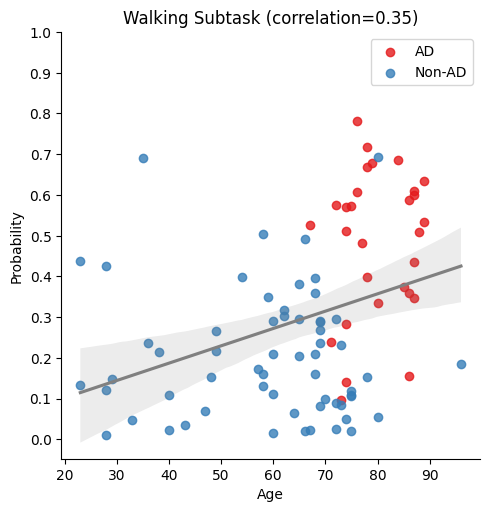

In [45]:
def show_weightedProb_age_relation(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        prob_list.append(prob)
        age_list.append(age)
        label_list.append(label)
            
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')

    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)

    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age'], result_df['Probability'])

    hue_order = ['AD', 'Non-AD']
    sns.lmplot(data=result_df, x="Age", y="Probability", hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette='Set1')
    ax = sns.regplot(data=result_df, x="Age", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()
    
show_weightedProb_age_relation(weightedProb_age_dict)

[Pid 4] age: 71, label: AD
[Pid 5] age: 75, label: Non-AD
[Pid 6] age: 80, label: Non-AD
[Pid 9] age: 87, label: AD
[Pid 10] age: 74, label: AD
[Pid 100] age: 68, label: Non-AD
[Pid 11] age: 74, label: AD
[Pid 12] age: 74, label: AD
[Pid 13] age: 75, label: Non-AD
[Pid 16] age: 78, label: AD
[Pid 17] age: 86, label: AD
[Pid 18] age: 86, label: AD
[Pid 19] age: 75, label: Non-AD
[Pid 20] age: 76, label: AD
[Pid 21] age: 74, label: Non-AD
[Pid 23] age: 88, label: AD
[Pid 24] age: 78, label: AD
[Pid 25] age: 78, label: AD
[Pid 26] age: 77, label: AD
[Pid 27] age: 79, label: AD
[Pid 28] age: 84, label: AD
[Pid 30] age: 67, label: Non-AD
[Pid 31] age: 85, label: AD
[Pid 32] age: 76, label: AD
[Pid 34] age: 69, label: Non-AD
[Pid 35] age: 80, label: AD
[Pid 36] age: 87, label: AD
[Pid 37] age: 86, label: AD
[Pid 38] age: 67, label: AD
[Pid 39] age: 73, label: AD
[Pid 40] age: 74, label: AD
[Pid 43] age: 72, label: Non-AD
[Pid 44] age: 96, label: Non-AD
[Pid 45] age: 89, label: AD
[Pid 46] ag

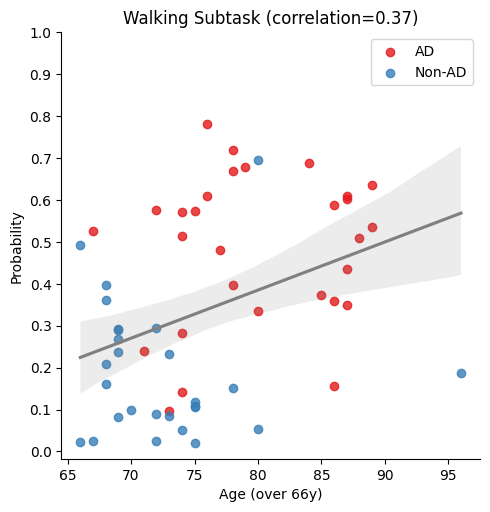

In [46]:
def show_weightedProb_age_relation_over66(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        if age>=66:
            prob_list.append(prob)
            age_list.append(age)
            label_list.append(label)
            print(f'[Pid {pid}] age: {age}, label: {label}')
            
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')

    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)

    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age (over 66y)'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age (over 66y)'], result_df['Probability'])

    sns.lmplot(data=result_df, x="Age (over 66y)", y="Probability", hue="Label", fit_reg=False, legend=False, palette='Set1')
    ax = sns.regplot(data=result_df, x="Age (over 66y)", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()
    
show_weightedProb_age_relation_over66(weightedProb_age_dict)

## AD only

Number of AD subjects: 29, Age: 67 ~ 89
Pearson correlation coefficient: 0.12


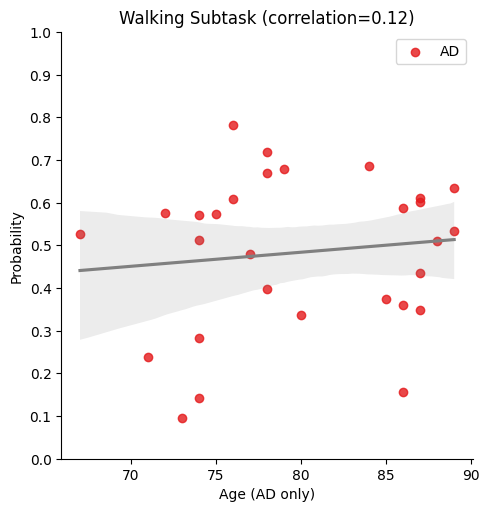

In [47]:
def show_weightedProb_age_relation_onlyAD(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        # if age>=66 and label=='AD':
        if label=='AD':
            prob_list.append(prob)
            age_list.append(age)
            label_list.append(label)
            
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of AD subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')

    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)

    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age (AD only)'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age (AD only)'], result_df['Probability'])

    sns.lmplot(data=result_df, x="Age (AD only)", y="Probability", hue="Label", fit_reg=False, legend=False, palette='Set1')
    ax = sns.regplot(data=result_df, x="Age (AD only)", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()

show_weightedProb_age_relation_onlyAD(weightedProb_age_dict)

## Non-AD only

Number of NonAD subjects: 60, Age: 23 ~ 96
Pearson correlation coefficient: -0.05


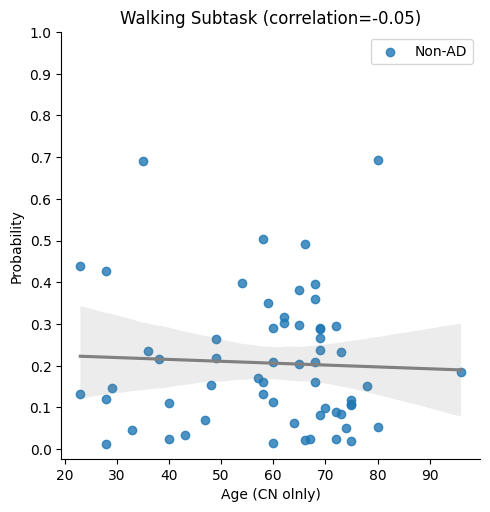

In [48]:
def show_weightedProb_age_relation_onlyCN(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        if label=='Non-AD':
            prob_list.append(prob)
            age_list.append(age)
            label_list.append(label)
    
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of NonAD subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')
            
    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)
    
    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age (CN olnly)'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age (CN olnly)'], result_df['Probability'])

    sns.lmplot(data=result_df, x="Age (CN olnly)", y="Probability", hue="Label", fit_reg=False, legend=False)
    ax = sns.regplot(data=result_df, x="Age (CN olnly)", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()

show_weightedProb_age_relation_onlyCN(weightedProb_age_dict)

# Small Group Performance

In [49]:
Age_group_list = [[20, 49], [50, 64], [65, 69], [70, 74], [75, 84], [85, 96]]


def analyze_each_AgeGroup_performance(result_dict, age_dict, groups):
    tmp_dict = {}
    for group_idx, age_group in enumerate(groups):
        lower = age_group[0]
        upper = age_group[1]
        
        n_subject = 0
        pred_list, actual_list = [], []
        for key in result_dict:
            pid = key
            age = Age_dict[pid]
            if age>=lower and age<=upper:
                n_subject += 1
                pred_list.append(result_dict[pid]['prediction'])
                actual_list.append(result_dict[pid]['actual'])
                
        print(f'[Age {lower}~{upper}] {n_subject} subjects')
        
        pred_array = np.array(pred_list)
        actual_array = np.array(actual_list)
        matrix = confusion_matrix(actual_array, pred_array)
        
        if matrix.shape==(1, 1) and actual_array[0]==0:
            TN = matrix[0, 0]
            FP = FN = TP = 0
        elif matrix.shape==(1, 1) and actual_array[0]==1:
            TP = matrix[0, 0]
            FP = FN = TN = 0
        else:
            TN, FP, FN, TP = matrix.ravel()
        
        eps = sys.float_info.epsilon
        value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
        value_sensitivity = round(TP/(TP+FN+eps), 4)
        value_specificity = round(TN/(TN+FP+eps), 4)
        value_precision = round(TP/(TP+FP+eps), 4)
        value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity+eps), 2)
        
        group_name = 'group_'+ str(group_idx)
        tmp_dict[group_name] = {}
        tmp_dict[group_name]['Accuracy'] = round(value_accuracy*100, 2)
        tmp_dict[group_name]['Sensitivity'] = round(value_sensitivity*100, 2)
        tmp_dict[group_name]['Specificity'] = round(value_specificity*100, 2)
        tmp_dict[group_name]['Precision'] = round(value_precision*100, 2)
        tmp_dict[group_name]['F1-score'] = round(value_f1_score, 2)
    return tmp_dict
    
age_group_result = analyze_each_AgeGroup_performance(result_dict_sorted, Age_dict, Age_group_list)

[Age 20~49] 17 subjects
[Age 50~64] 13 subjects
[Age 65~69] 16 subjects
[Age 70~74] 14 subjects
[Age 75~84] 17 subjects
[Age 85~96] 12 subjects


In [50]:
age_group_result

{'group_0': {'Accuracy': 76.47,
  'Sensitivity': 0.0,
  'Specificity': 76.47,
  'Precision': 0.0,
  'F1-score': 0.0},
 'group_1': {'Accuracy': 38.46,
  'Sensitivity': 0.0,
  'Specificity': 38.46,
  'Precision': 0.0,
  'F1-score': 0.0},
 'group_2': {'Accuracy': 68.75,
  'Sensitivity': 100.0,
  'Specificity': 66.67,
  'Precision': 16.67,
  'F1-score': 0.29},
 'group_3': {'Accuracy': 42.86,
  'Sensitivity': 14.29,
  'Specificity': 71.43,
  'Precision': 33.33,
  'F1-score': 0.2},
 'group_4': {'Accuracy': 70.59,
  'Sensitivity': 60.0,
  'Specificity': 85.71,
  'Precision': 85.71,
  'F1-score': 0.71},
 'group_5': {'Accuracy': 33.33,
  'Sensitivity': 27.27,
  'Specificity': 100.0,
  'Precision': 100.0,
  'F1-score': 0.43}}